In [1]:
import dask as da
import dask.dataframe as daskdf
import dask.array as daa
import dask.distributed as dd
import dask.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import sklearn as sk
import numpy as np
import dask_ml.preprocessing as dm_pre
import dask_ml.cluster as dm_cluster
import dask_geopandas as dg
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from scipy.stats import pearsonr
import time

# phase 1 : business understanding:
The National Railway Company of Belgium SNCB is responsible for
organizing and operating the rail service in Belgium. Within SNCB, the
Technics directorate is tasked with acquiring, updating, and maintaining the
rolling stock. Their objective is to deliver a superior service by ensuring the
availability of an ample supply of safe, dependable, and comfortable rolling
stock tailored to meet both operational and commercial requirements of
customers
1
. This project is sponsored by the rolling stock team, who
provide the data and the technical challenge.
The context of this challenge is the cooling of diesel trains
2
. SNCB’s diesel
trains are AR41 (Belgian Railways Class 41 - Wikipedia) and consist of 2
vehicles which are always coupled. Each of these vehicles is referenced in
the data: some_variable_name_PC1 and some_variable_name_PC2. Each
PC is equipped with 2 cooling systems: one for the engine air intake and
one for the oil of the transmission. In the latter, the water is the coolant
(water-oil intercooler) while in the former air is used as coolant (air-air
intercooler).
Maintaining these systems working properly is important for the health of
the diesel engines and transmission and to avoid incidents. In operations, if
one of the engines fails, then the other can serve as a backup. However, if
the backup fails then there will be a train delay. It is of everybody’s interest
to keep both engines working properly and making sure the temperatures
and pressures stay within acceptable ranges.
2 5% of SNCB trains are diesel-powered, 95% electric.
1 https://www.belgiantrain.be/en/about-sncb/enterprise/management-structure/directions/technics
The maximum acceptable temperatures are for the: air: 65°C, water:
100°C, oil: 115°C. Above those thresholds the engines are stopped
automatically to avoid damage.
Just like in life, problems arise. Here the anomalies could come from: a
sensor, a cooling system, an engine, both engines, or external sources:
weather is too hot, pollen gets stuck into the radiators, etc. Being able to
capture and to distinguish some of these potential failures and to predict
them in advance will help preserve vehicles’ health and prevent train
incidents.


# phase 2 : data understanding 
This phase involves initial data collection, increasing familiarity with data, identifying quality problems, and forming hypotheses. Steps include collecting initial data, describing data, exploring data, and verifying data quality.

Collect the Initial Data:

Acquire necessary data, report encountered problems and solutions.
Describe the Data:

Examine data format, quantity, structure, and other surface features.
Ensure data meets relevant requirements.
Explore the Data:

Use querying, visualization, and reporting to answer data mining questions.
Create a data exploration report with initial findings.
Verify Data Quality:

Examine data completeness, missing values, attribute meanings, and anomalies.
Address quality problems reported in the earlier step.



In [2]:
"""data look like this: ;mapped_veh_id;timestamps_UTC;lat;lon;RS_E_InAirTemp_PC1;RS_E_InAirTemp_PC2;RS_E_OilPress_PC1;RS_E_OilPress_PC2;RS_E_RPM_PC1;RS_E_RPM_PC2;RS_E_WatTemp_PC1;RS_E_WatTemp_PC2;RS_T_OilTemp_PC1;RS_T_OilTemp_PC2
0;181;2023-08-01 03:44:12;50.7698183;3.8721144;27.0;23.0;255.0;238.0;794.0;801.0;83.0;81.0;76.0;77.0
1;143;2023-08-01 06:36:29;51.0399934;3.6934285;33.0;32.0;272.0;324.0;802.0;804.0;78.0;78.0;73.0;74.0
2;183;2023-08-24 06:53:54;50.7422026;3.6020347;31.0;33.0;234.0;182.0;799.0;802.0;82.0;82.0;85.0;87.0"""
# Load data
def load_data():
    print("Loading data...")
    start = time.time()
    df = daskdf.read_csv("ar41_for_ulb.csv", sep=';')
    end = time.time()
    print("Data loaded in {} seconds".format(end-start))
    return df

ddf = load_data()
ddf = ddf.drop(columns=['Unnamed: 0'])
# convert all temperatures from celcius to kelvin
ddf['RS_E_InAirTemp_PC1'] = ddf['RS_E_InAirTemp_PC1'] + 273.15
ddf['RS_E_InAirTemp_PC2'] = ddf['RS_E_InAirTemp_PC2'] + 273.15
ddf['RS_E_WatTemp_PC1'] = ddf['RS_E_WatTemp_PC1'] + 273.15
ddf['RS_E_WatTemp_PC2'] = ddf['RS_E_WatTemp_PC2'] + 273.15
ddf['RS_T_OilTemp_PC1'] = ddf['RS_T_OilTemp_PC1'] + 273.15
ddf['RS_T_OilTemp_PC2'] = ddf['RS_T_OilTemp_PC2'] + 273.15


Loading data...
Data loaded in 0.04009532928466797 seconds


In [3]:
# lets sample data 
def take_sample(df, frac):
    print("Taking sample...")
    start = time.time()
    df = df.sample(frac=frac)
    end = time.time()
    print("Sample taken in {} seconds".format(end-start))
    return df

#ddf = take_sample(ddf, 0.0001)


In [4]:
# data description
def data_description(df):
    print("Data description:")
    print(df.head())
    print(df.shape)
    print("dataframe description")
    print(df.describe())

data_description(ddf)

Data description:


   mapped_veh_id       timestamps_UTC        lat       lon  \
0          181.0  2023-08-01 03:44:12  50.769818  3.872114   
1          143.0  2023-08-01 06:36:29  51.039993  3.693429   
2          183.0  2023-08-24 06:53:54  50.742203  3.602035   
3          177.0  2023-08-01 13:53:38  50.930914  5.327132   
4          143.0  2023-08-24 07:02:30  51.180773  3.575259   

   RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0              300.15              296.15              255.0   
1              306.15              305.15              272.0   
2              304.15              306.15              234.0   
3              308.15              311.15              220.0   
4              314.15              307.15              227.0   

   RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
0              238.0         794.0         801.0            356.15   
1              324.0         802.0         804.0            351.15   
2              182.0         799

Exploring RS_E_InAirTemp_PC1...
count    1.767927e+07
mean     3.051742e+02
std      3.280040e+02
min      2.731500e+02
25%      2.991500e+02
50%      3.081500e+02
75%      3.131500e+02
max      6.580815e+04
Name: RS_E_InAirTemp_PC1, dtype: float64
17678824


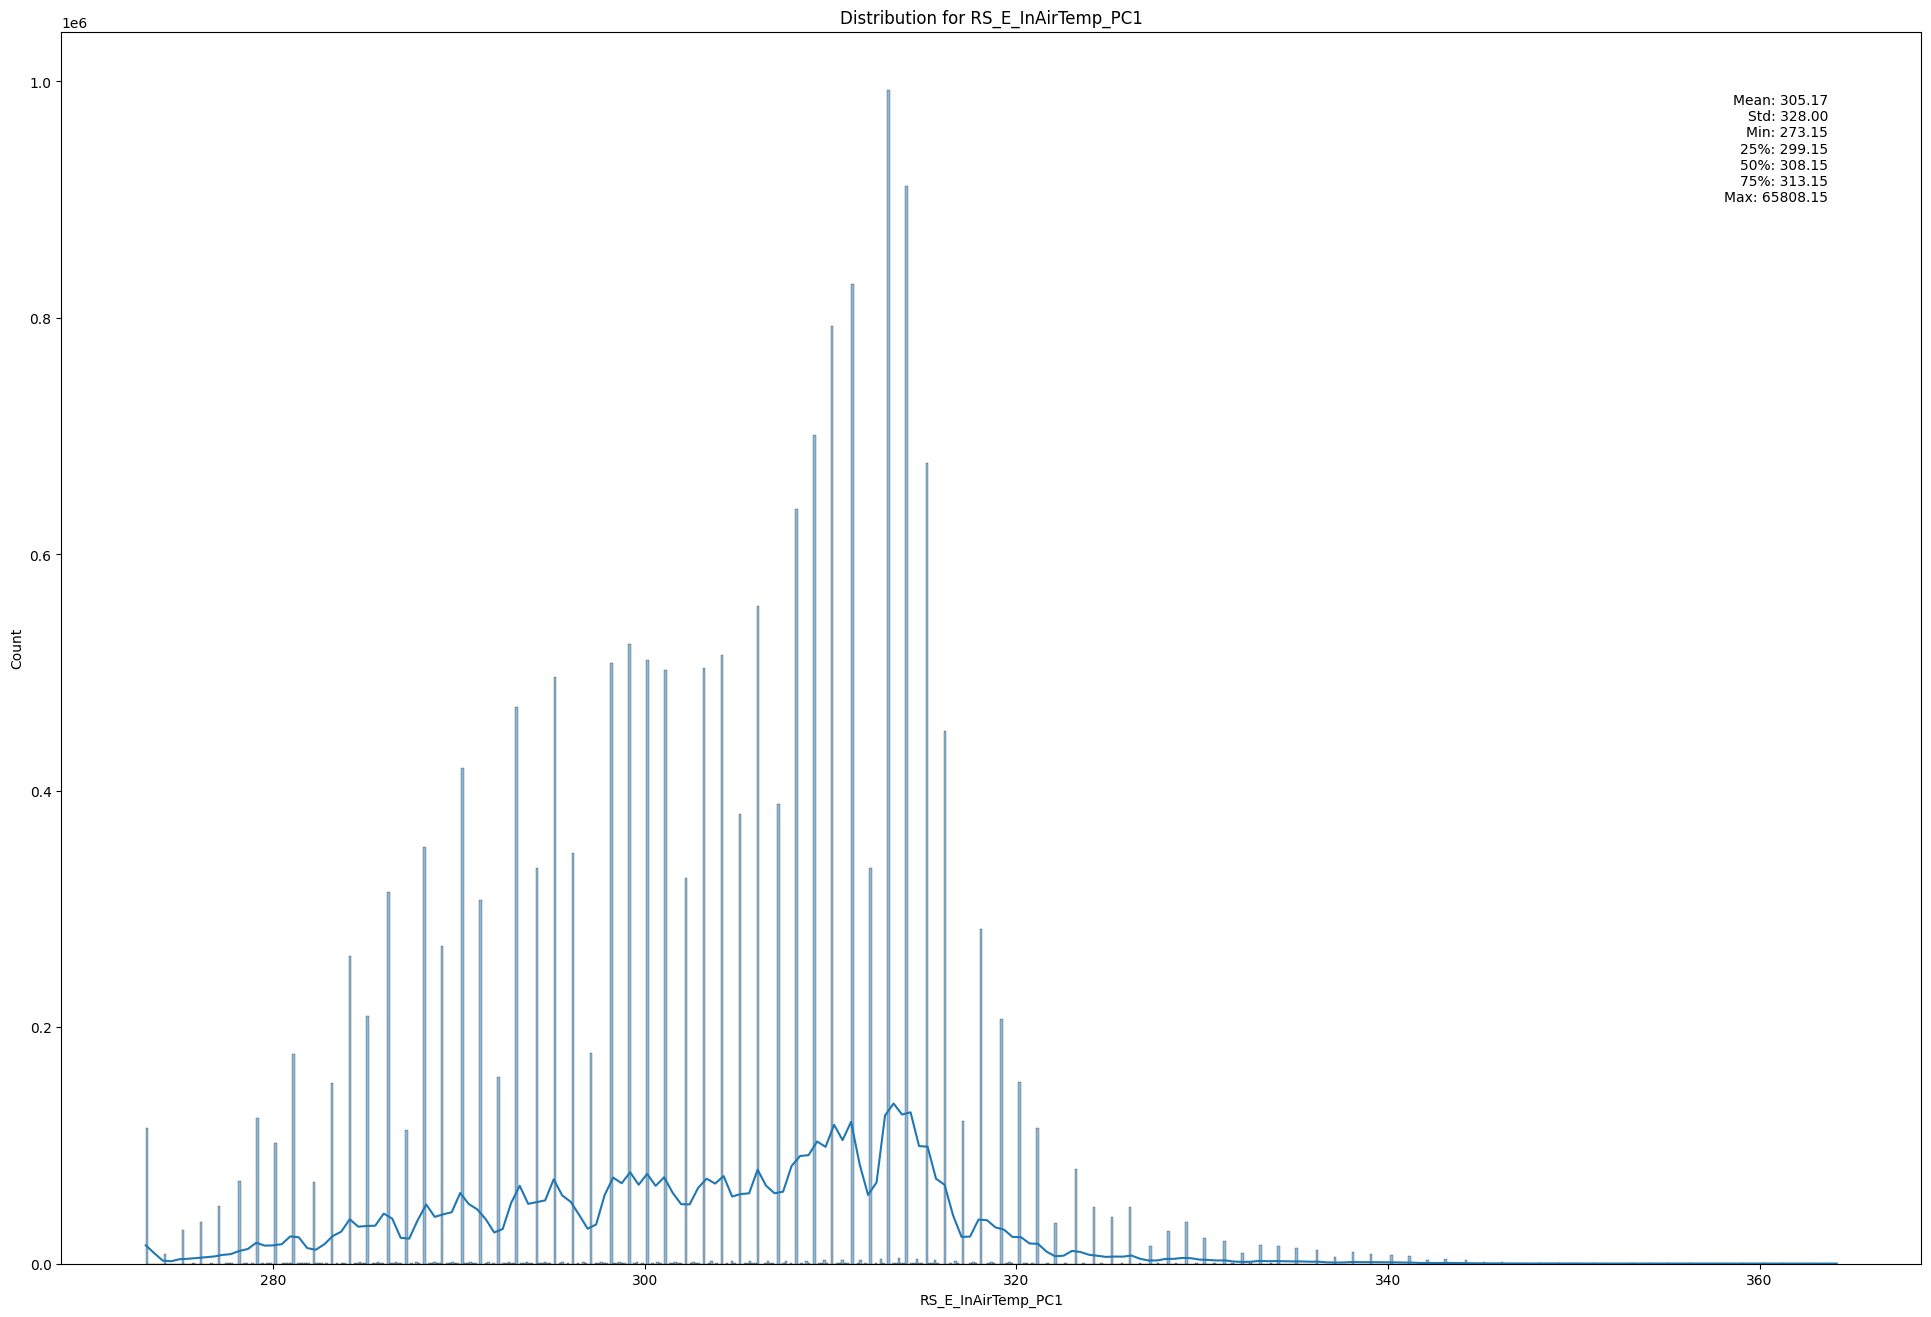

Exploring RS_E_InAirTemp_PC2...
count    1.766655e+07
mean     3.054841e+02
std      3.479992e+02
min      2.731500e+02
25%      2.991500e+02
50%      3.081500e+02
75%      3.131500e+02
max      6.580815e+04
Name: RS_E_InAirTemp_PC2, dtype: float64
17666041


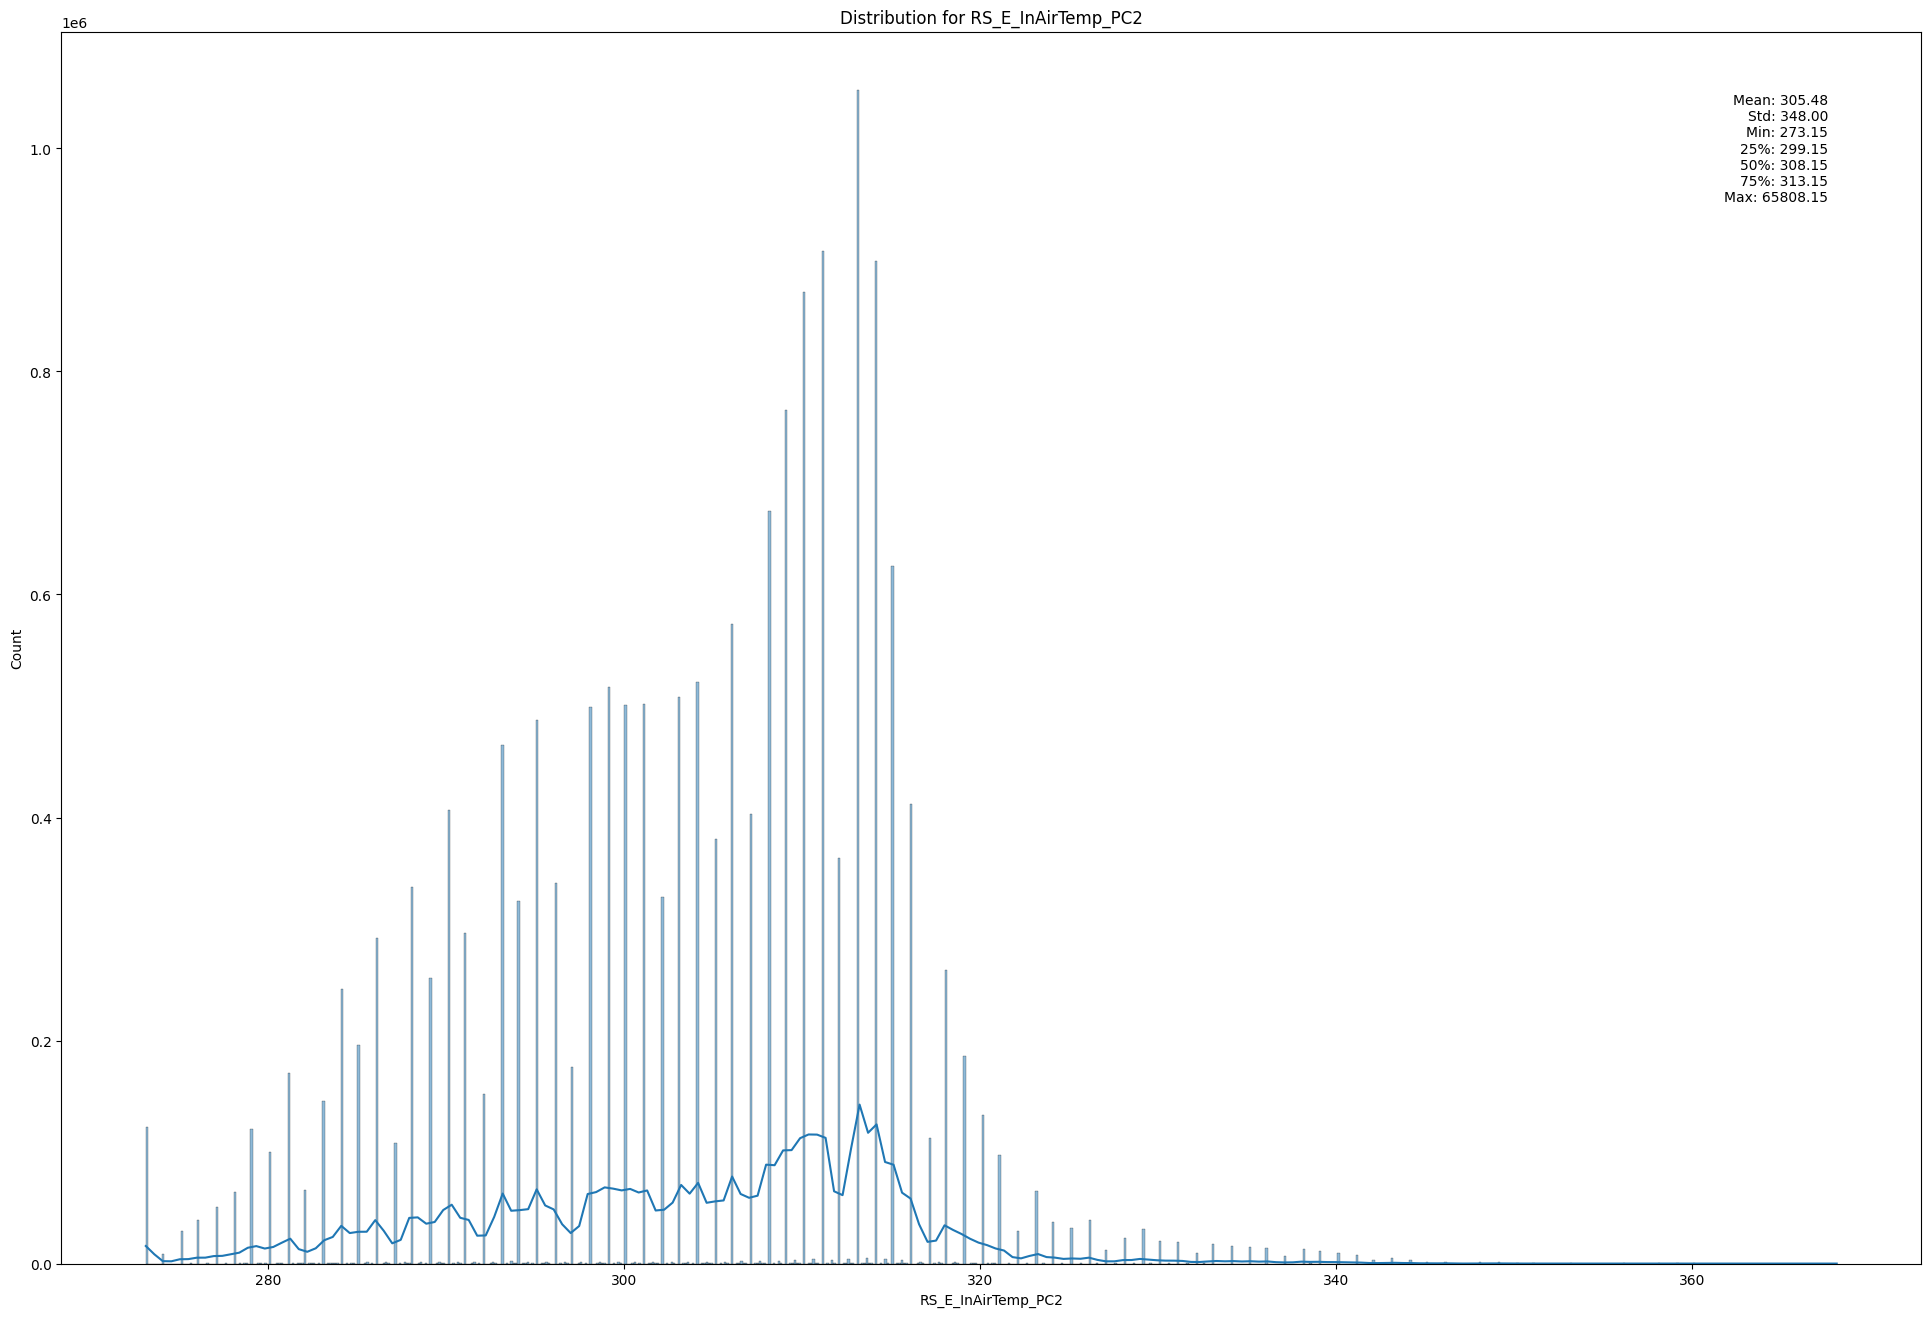

Exploring RS_E_RPM_PC1...
count    1.767927e+07
mean     9.122489e+02
std      3.833051e+02
min      0.000000e+00
25%      7.980000e+02
50%      8.010000e+02
75%      8.140000e+02
max      2.309000e+03
Name: RS_E_RPM_PC1, dtype: float64
17668508


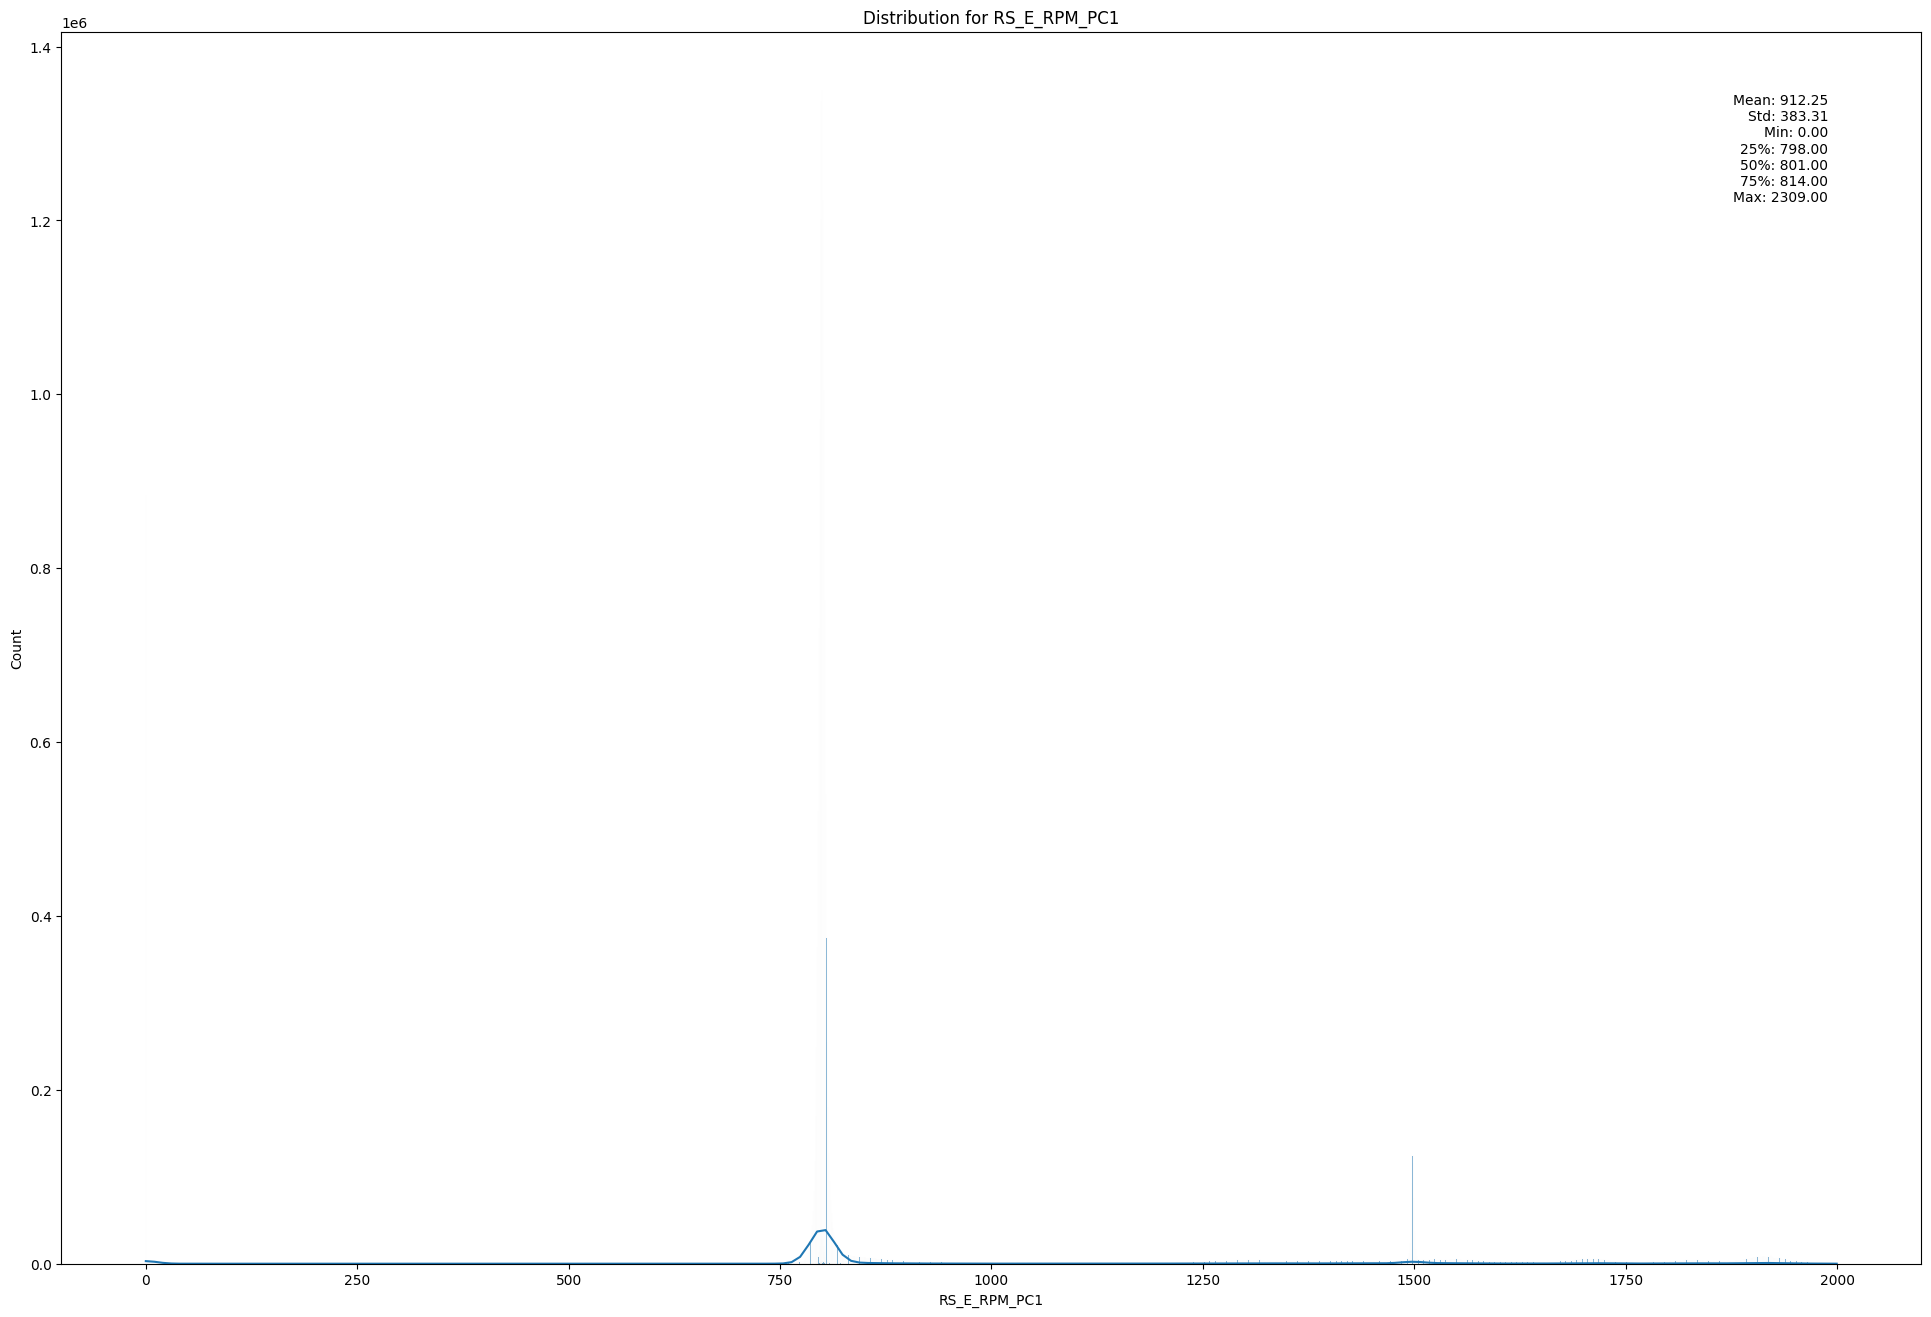

Exploring RS_E_RPM_PC2...
count    1.766655e+07
mean     9.079636e+02
std      3.884709e+02
min      0.000000e+00
25%      7.970000e+02
50%      8.010000e+02
75%      8.130000e+02
max      9.732000e+03
Name: RS_E_RPM_PC2, dtype: float64
17648908


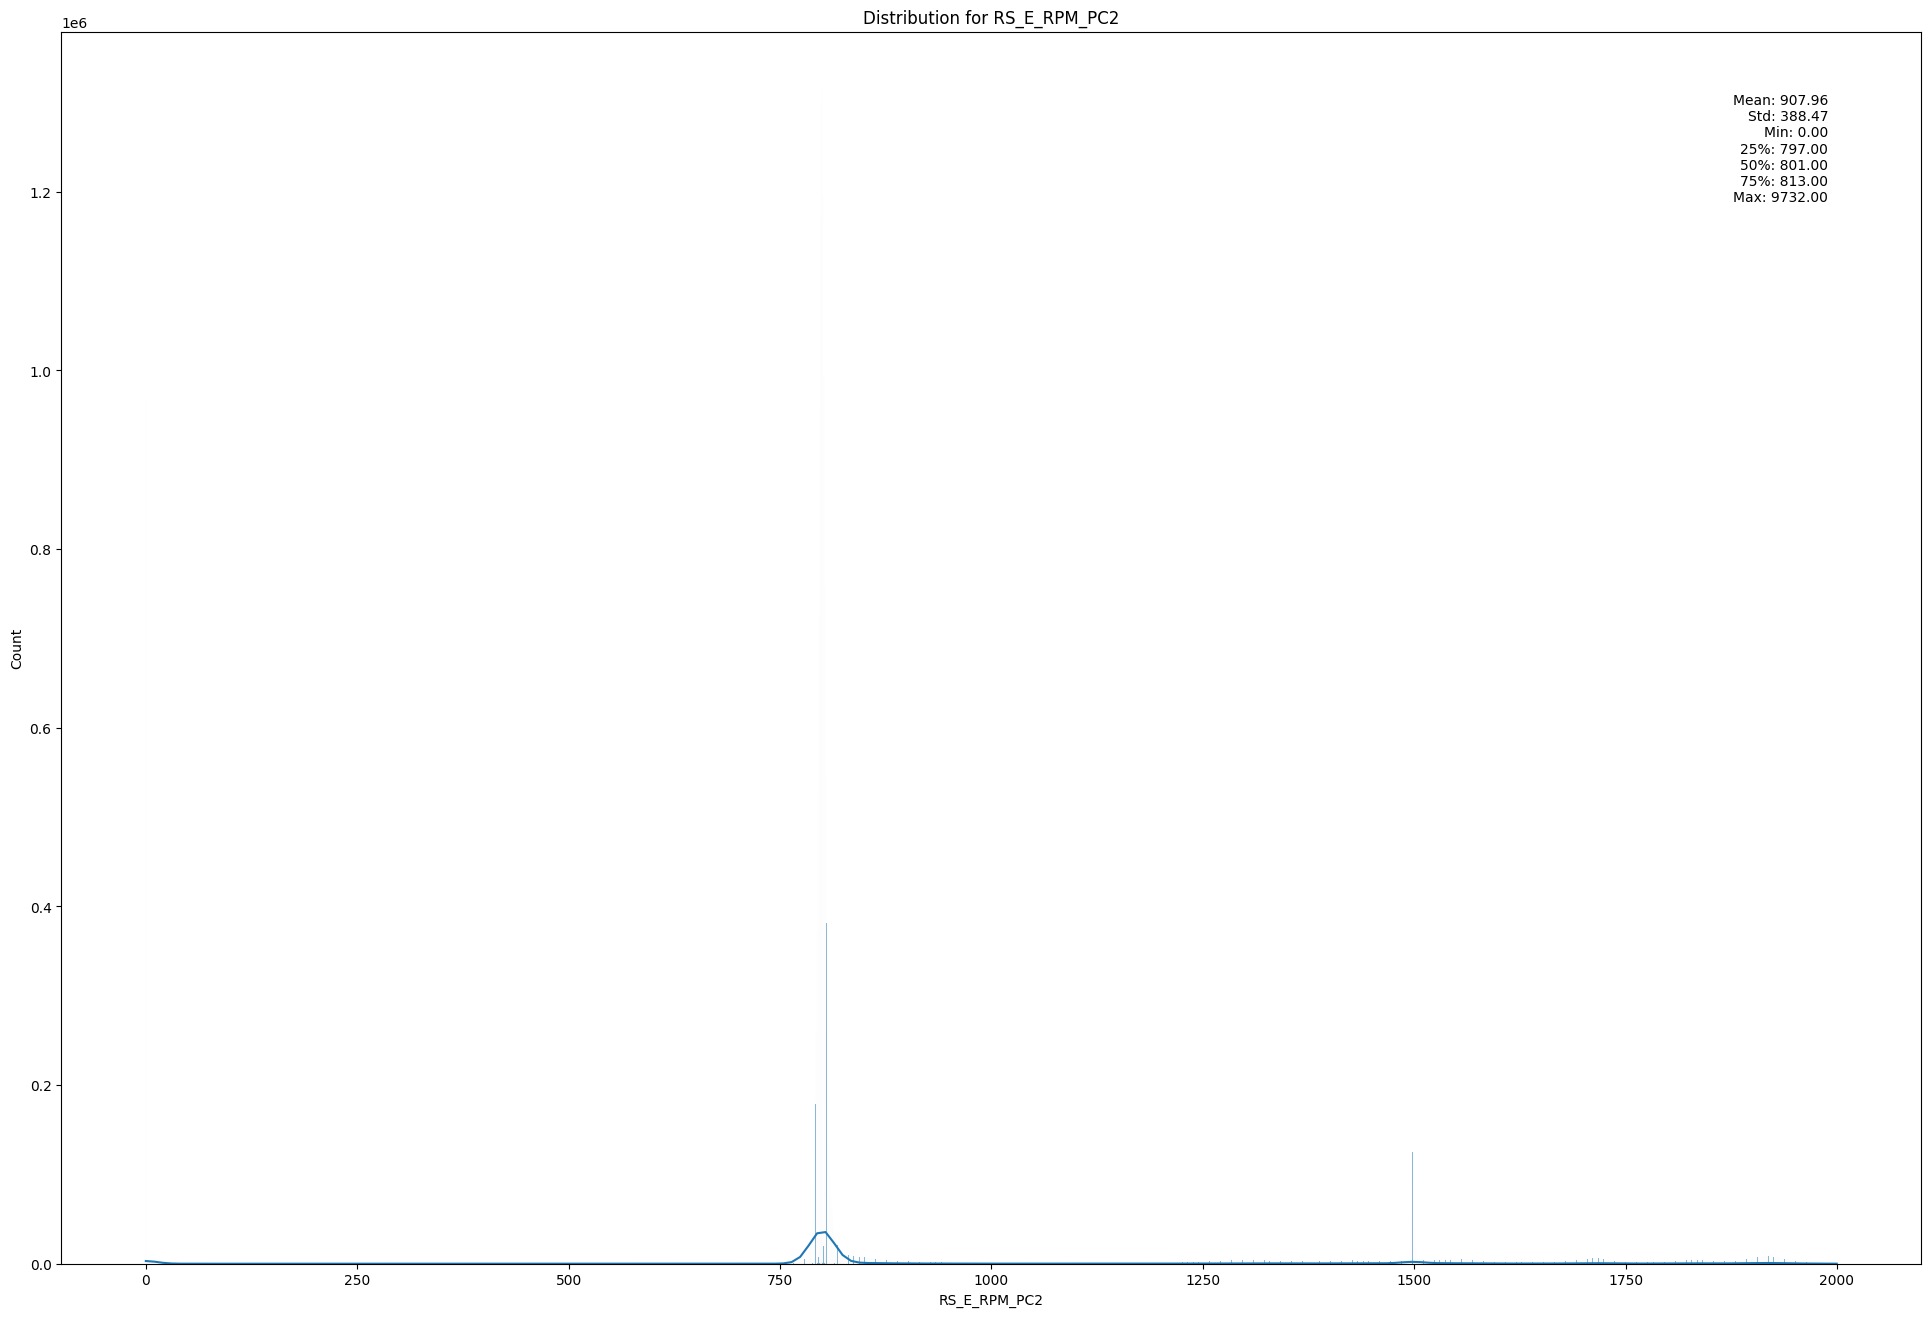

Exploring RS_E_WatTemp_PC1...
count    1.767927e+07
mean     3.500817e+02
std      1.365462e+01
min      2.581500e+02
25%      3.511500e+02
50%      3.541500e+02
75%      3.581500e+02
max      3.821500e+02
Name: RS_E_WatTemp_PC1, dtype: float64
17679220


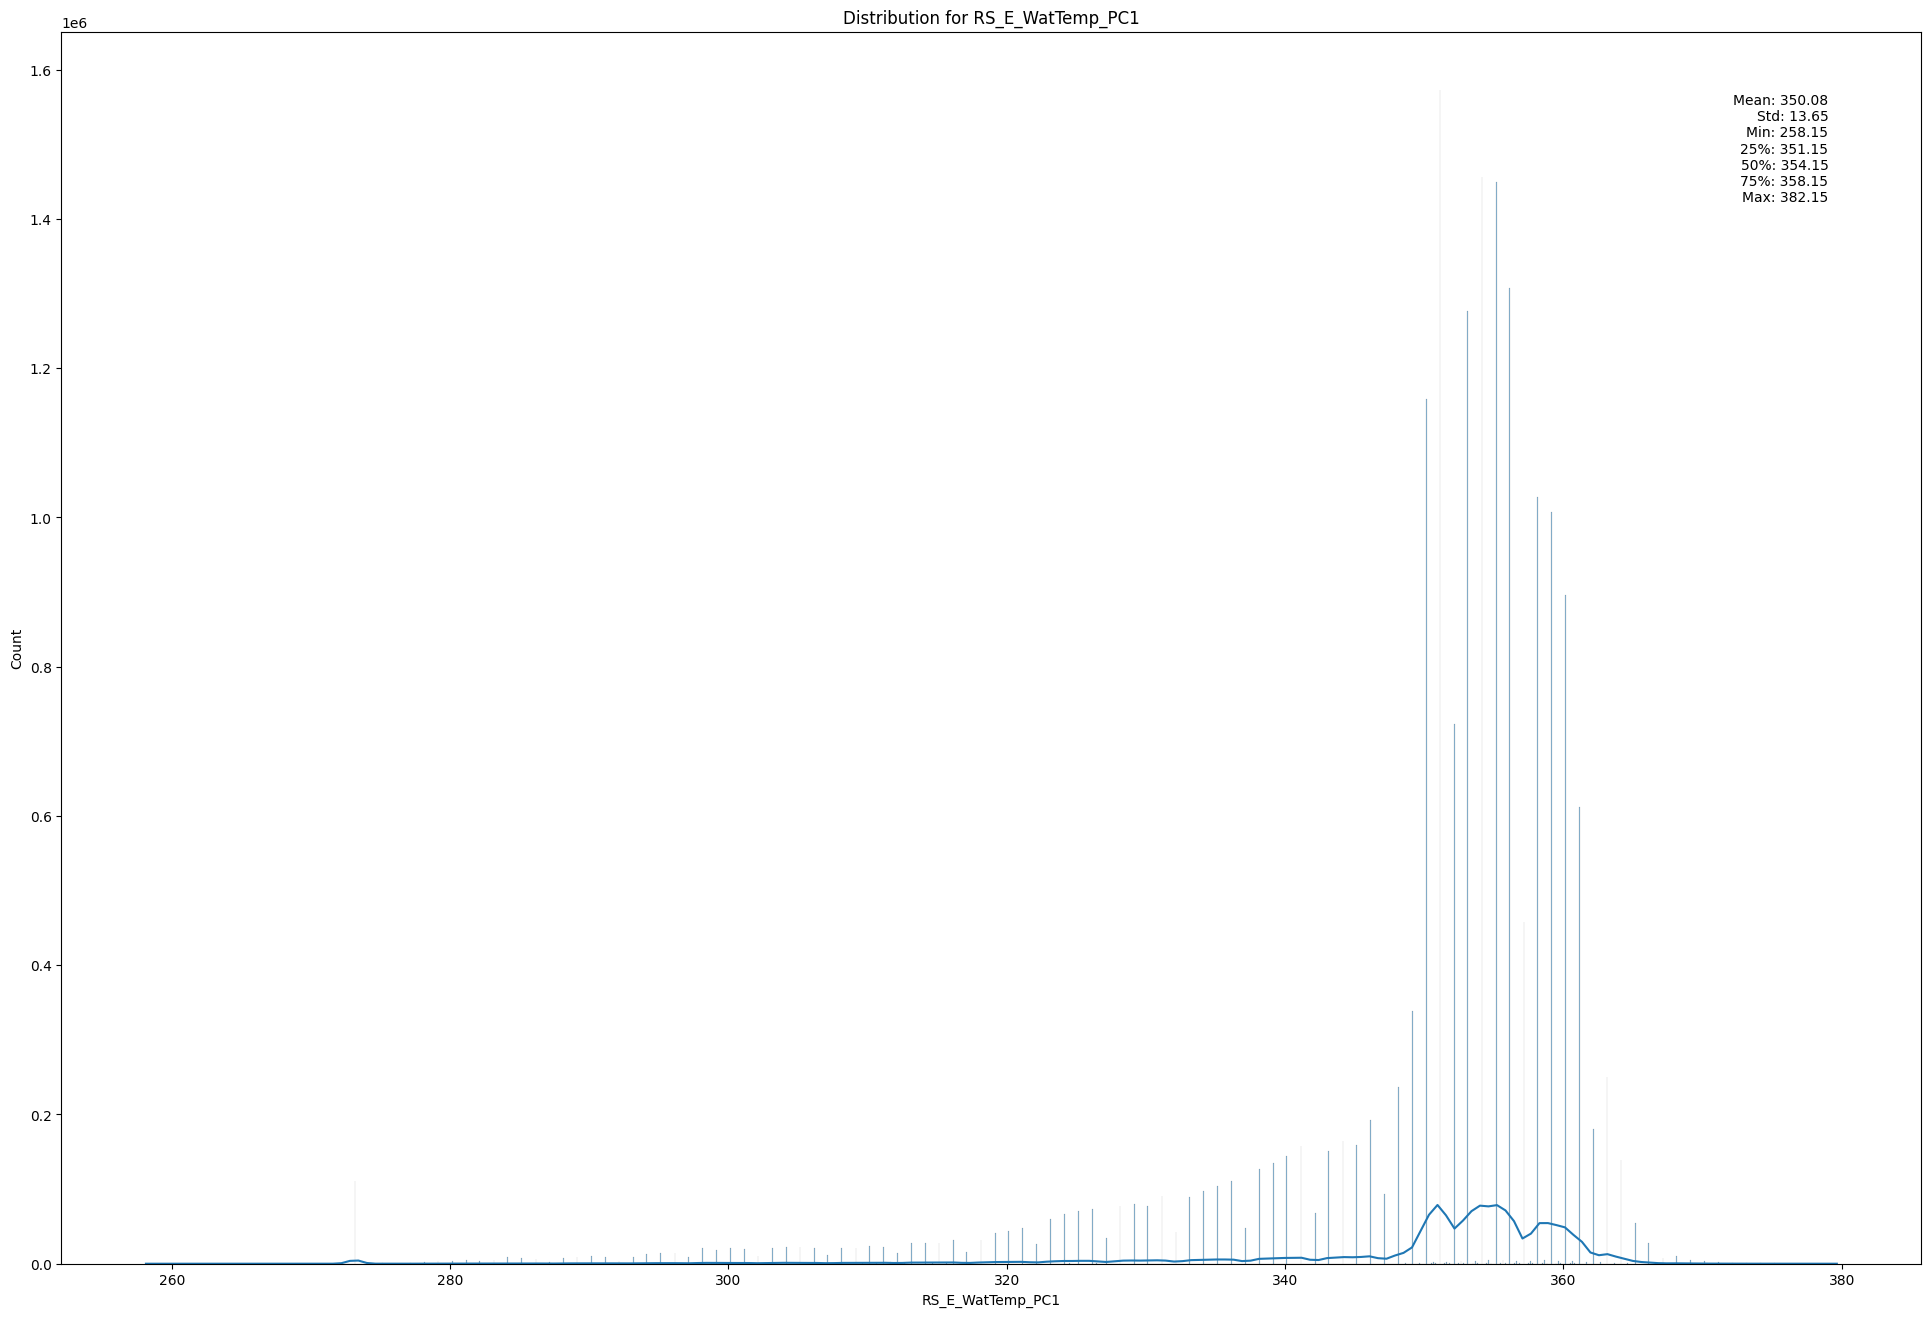

Exploring RS_E_WatTemp_PC2...
count    1.766655e+07
mean     3.492923e+02
std      1.452870e+01
min      2.561500e+02
25%      3.501500e+02
50%      3.541500e+02
75%      3.581500e+02
max      3.921500e+02
Name: RS_E_WatTemp_PC2, dtype: float64
17666541


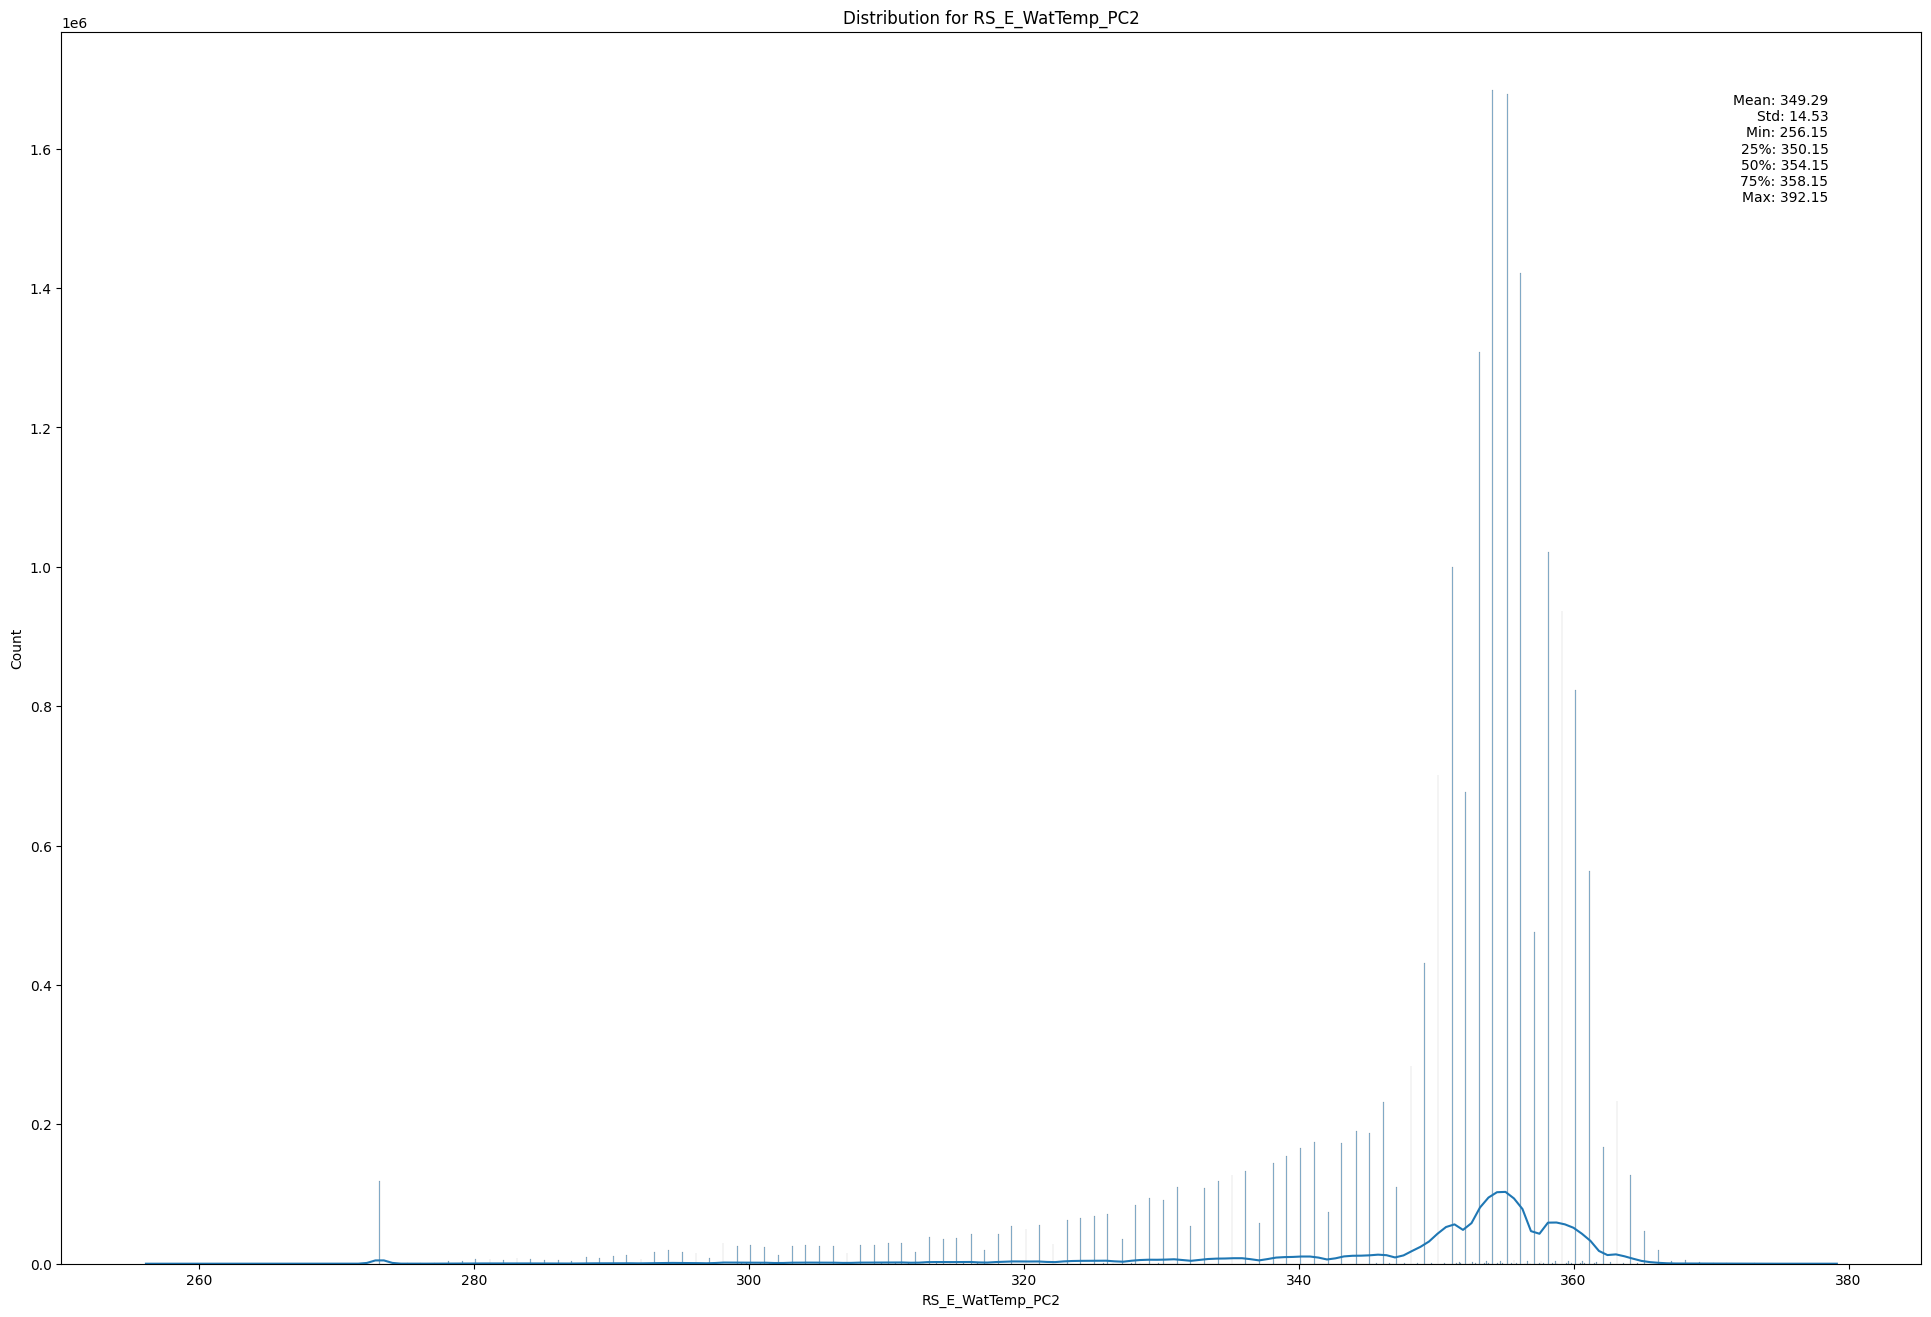

Exploring RS_T_OilTemp_PC1...
count    1.767927e+07
mean     3.496969e+02
std      1.450369e+01
min      1.451500e+02
25%      3.491500e+02
50%      3.541500e+02
75%      3.581500e+02
max      4.001500e+02
Name: RS_T_OilTemp_PC1, dtype: float64
5709586


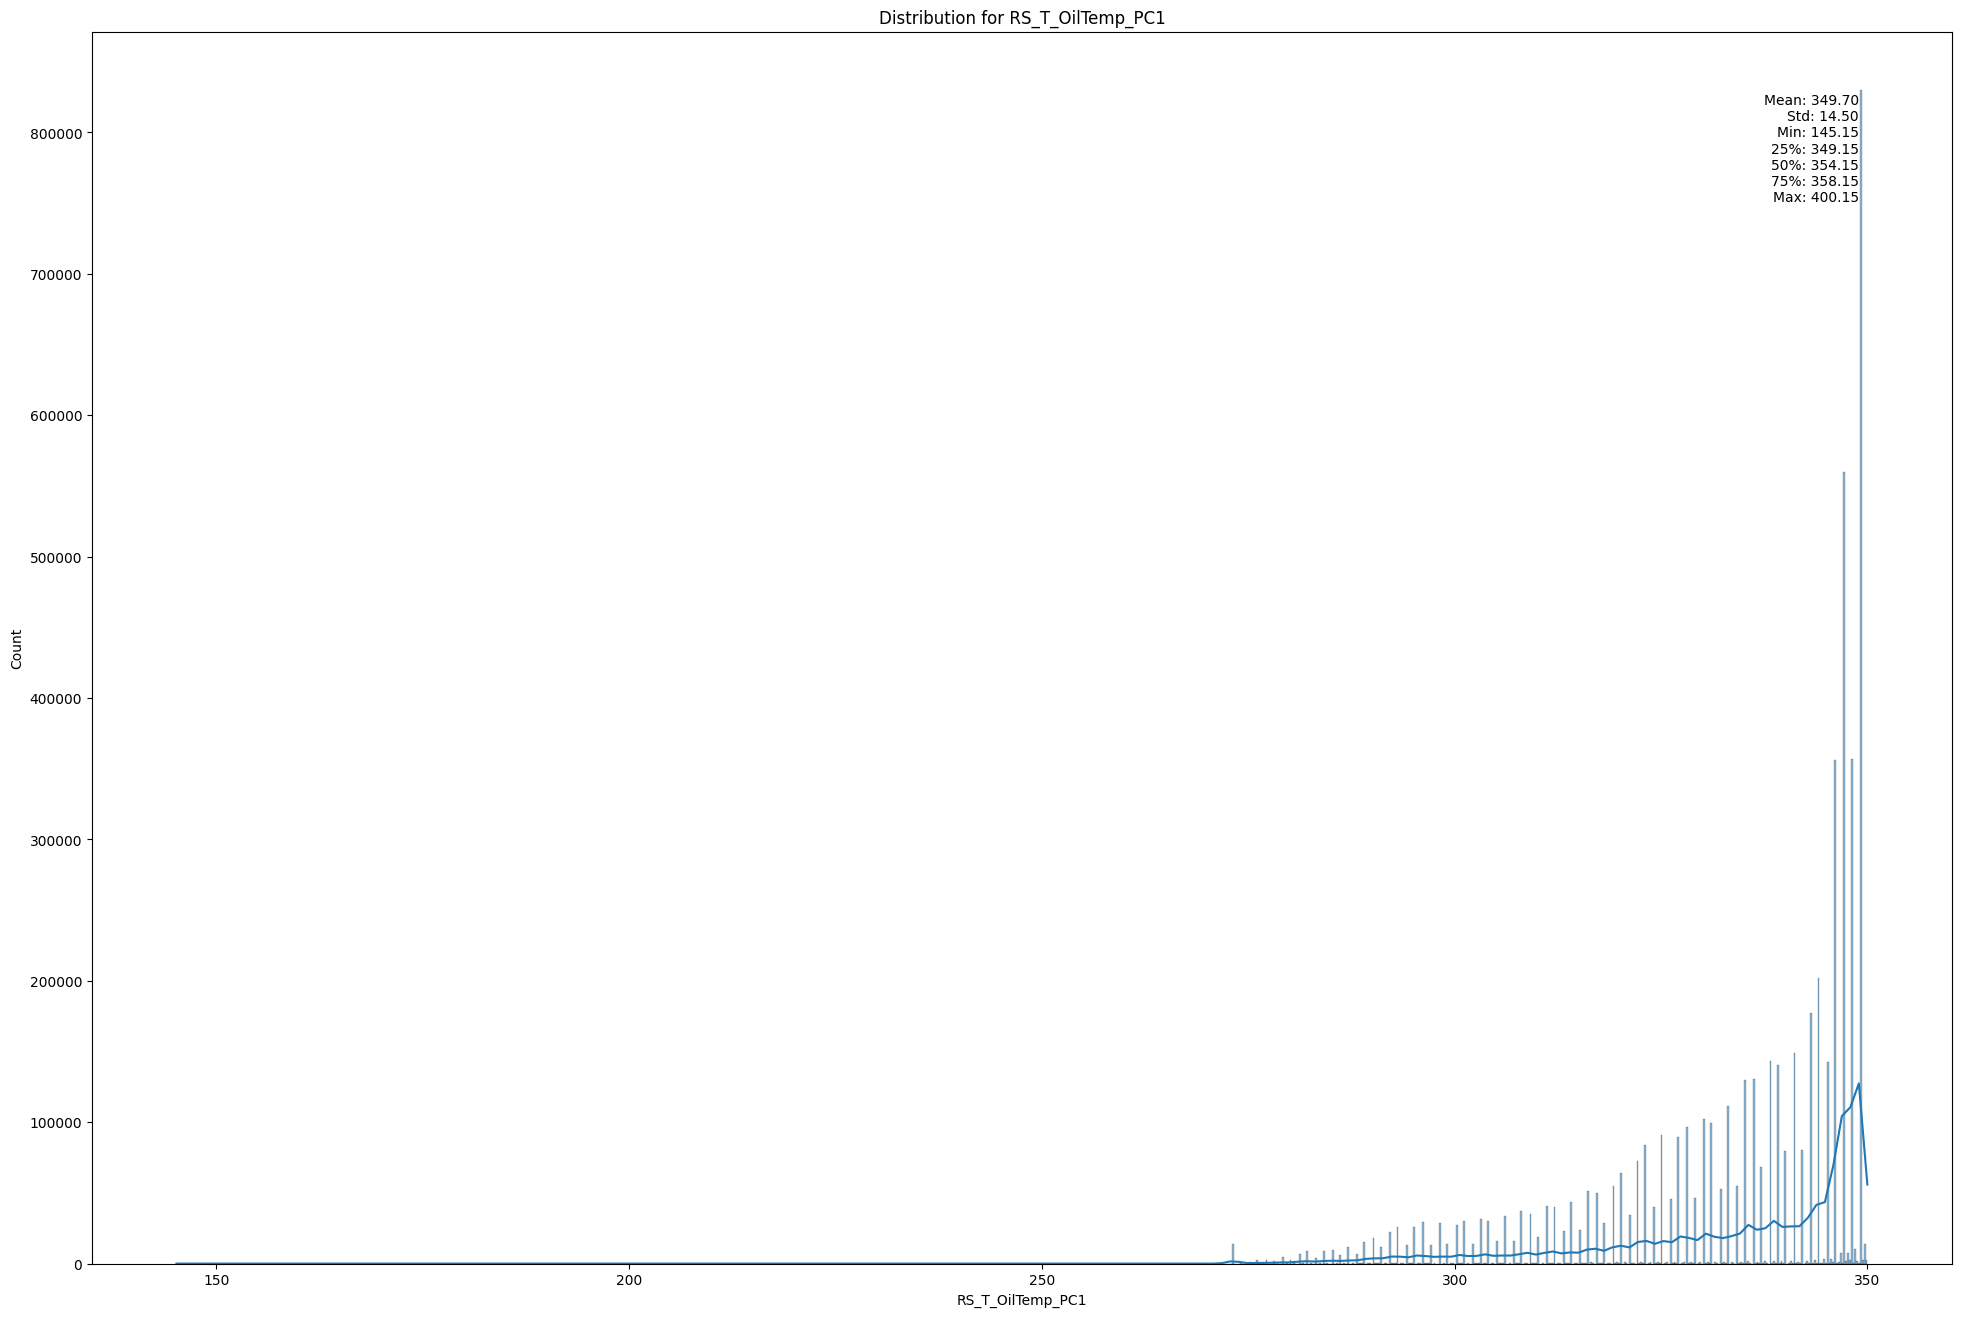

Exploring RS_T_OilTemp_PC2...
count    1.766655e+07
mean     3.493118e+02
std      1.535040e+01
min      2.731500e+02
25%      3.491500e+02
50%      3.541500e+02
75%      3.591500e+02
max      3.901500e+02
Name: RS_T_OilTemp_PC2, dtype: float64
5523927


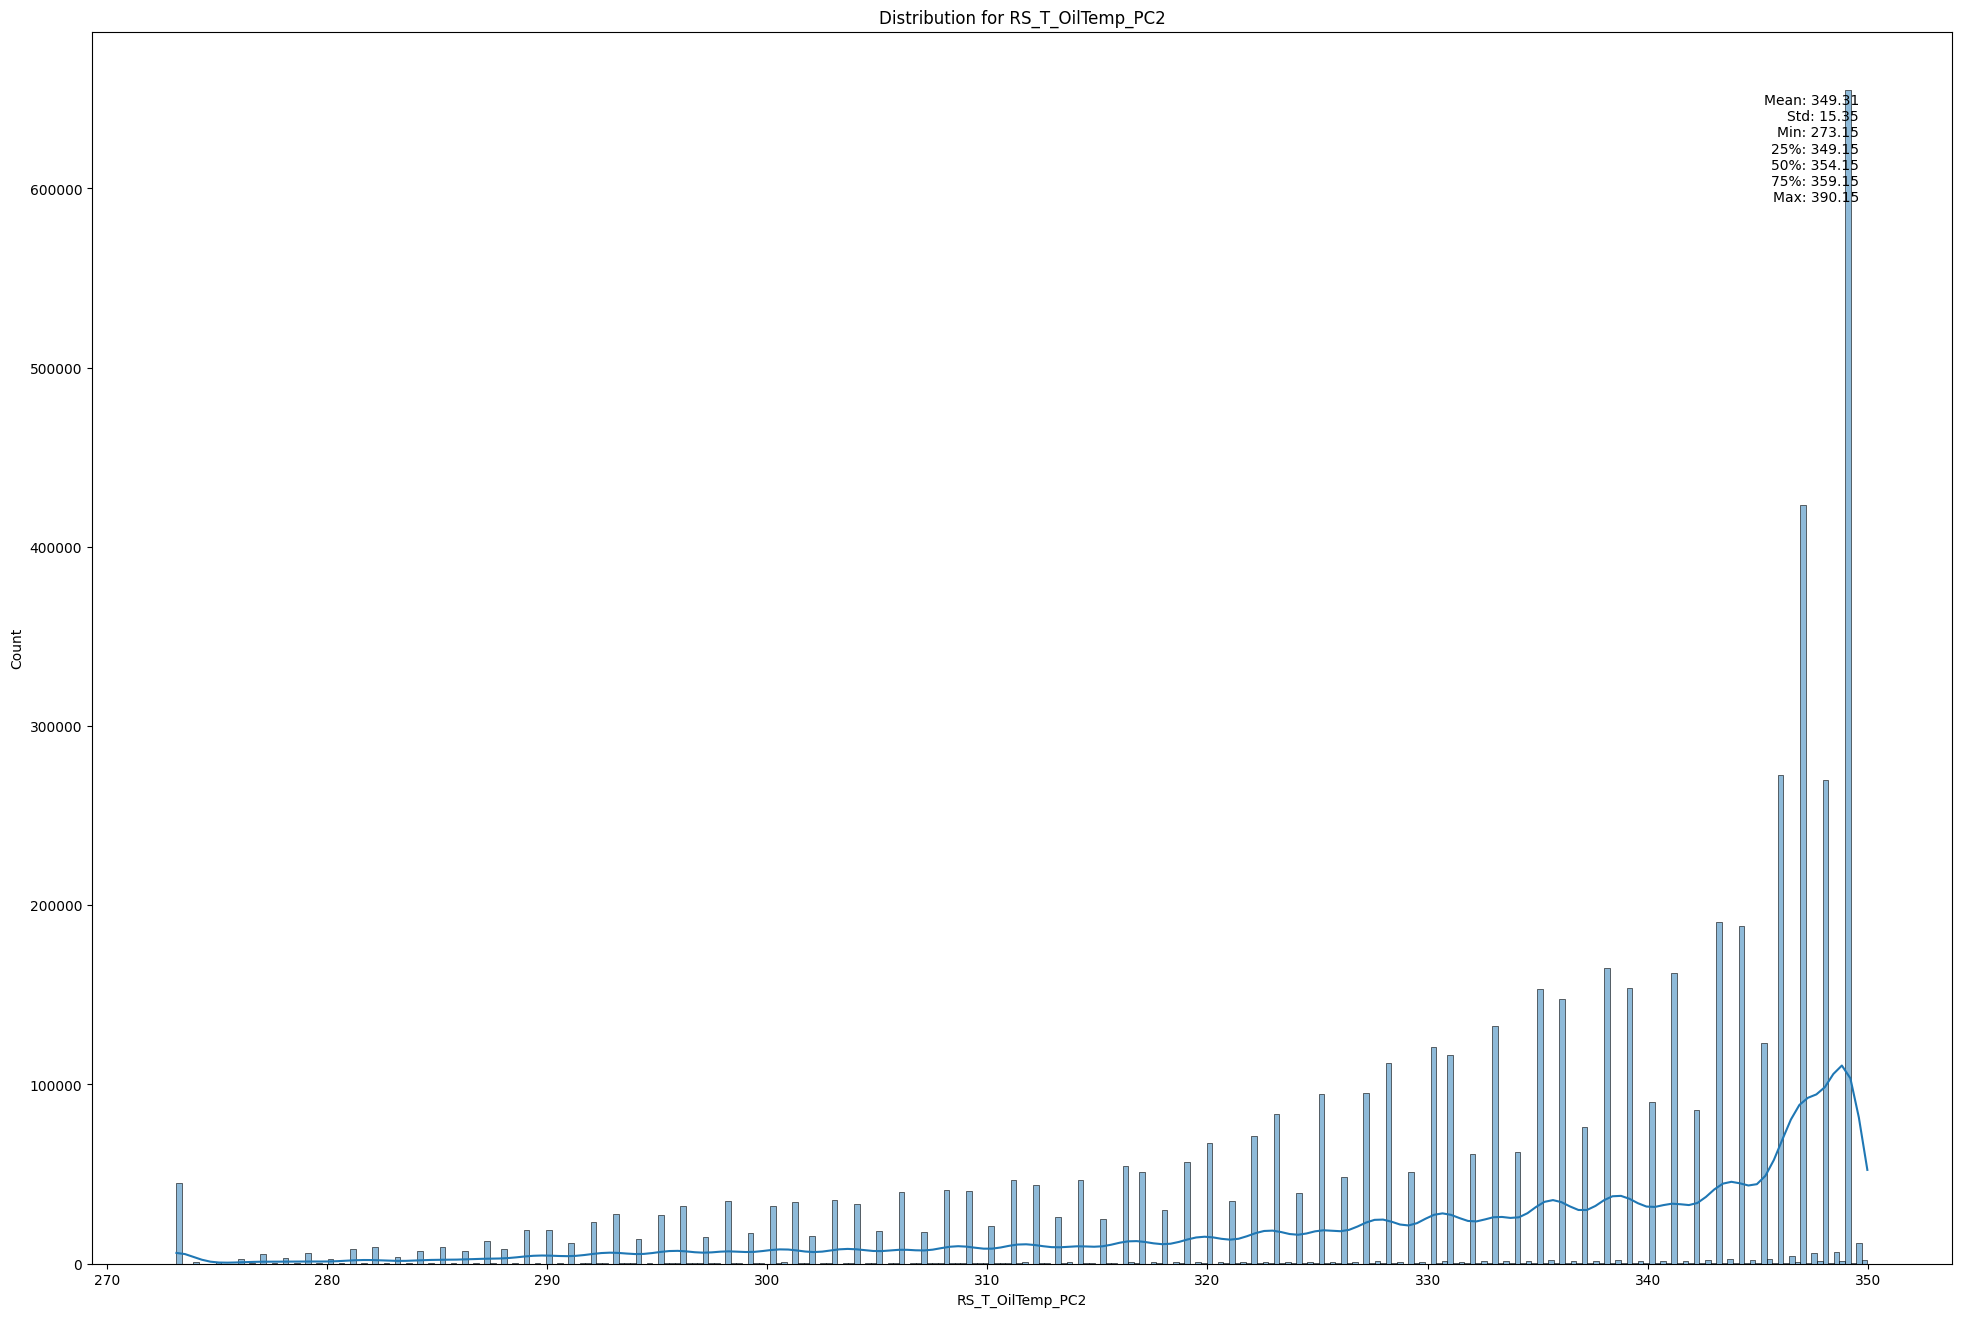

In [5]:
def data_exploration_and_viz(df):
    for col in df.columns:
        if col in ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2']:
            print(f"Exploring {col}...")
            col_description = df[col].describe().compute()
            print(col_description)

            # Plot distribution of each row item 
            plt.figure(figsize=(24, 16))
            #col_counts = df[col].value_counts().compute()
            #sns.barplot(x=col_counts.index, y=col_counts)
            #plt.title(f"Counts for {col}")
            #plt.show()
            # if col is RS_E_InAirTemp_PC1, filter value above 380 kelvin (107 degrees celcius)
            if col == 'RS_E_InAirTemp_PC1' or col == 'RS_E_InAirTemp_PC2' :
                dfs = df[df[col] < 380]
                print(len(dfs))
            elif col == 'RS_E_WatTemp_PC1' or col == 'RS_E_WatTemp_PC2':
                dfs = df[df[col] < 380]
                print(len(dfs))
            elif col == 'RS_T_OilTemp_PC1' or col == 'RS_T_OilTemp_PC2':
                dfs = df[df[col] < 350]
                print(len(dfs))
            elif col == 'RS_E_RPM_PC1' or col == 'RS_E_RPM_PC2':
                dfs = df[df[col] < 2000]
                print(len(dfs))
            sns.histplot(data=dfs[col].compute(), kde=True)
            plt.title(f"Distribution for {col}")
            plt.text(0.95, 0.95, f"Mean: {col_description['mean']:.2f}\nStd: {col_description['std']:.2f}\nMin: {col_description['min']:.2f}\n25%: {col_description['25%']:.2f}\n50%: {col_description['50%']:.2f}\n75%: {col_description['75%']:.2f}\nMax: {col_description['max']:.2f}", 
                     ha='right', va='top', transform=plt.gca().transAxes)
            plt.show()

data_exploration_and_viz(ddf)

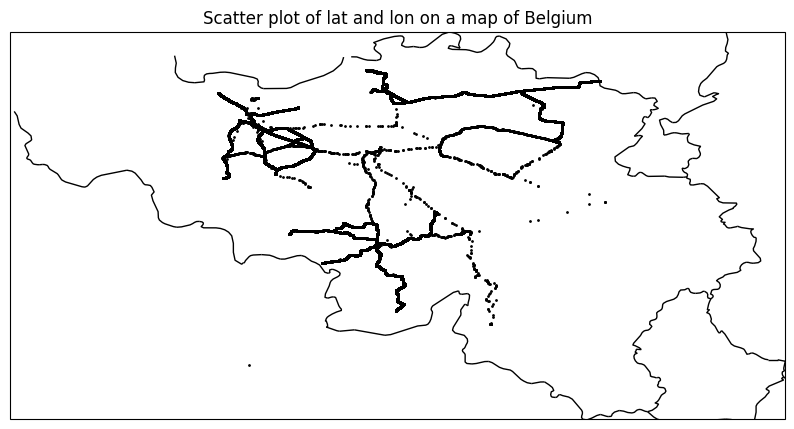

In [6]:
def map_visualization(df):
    # Scatter plot of 'lat' and 'lon' on a map of Belgium
    sample_df = df[['lat', 'lon']].sample(frac=0.1).compute()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([2.5, 6.5, 49.5, 51.5], crs=ccrs.PlateCarree())  # Set the extent to cover Belgium

    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='white')

    ax.scatter(sample_df['lon'], sample_df['lat'], s=1, color='black', transform=ccrs.PlateCarree())

    plt.title('Scatter plot of lat and lon on a map of Belgium')
    plt.show()



map_visualization(ddf)


In [7]:
from dask.distributed import Client
import dask_ml.preprocessing as dm_pre
import dask_ml.cluster as dm_cluster
import dask_geopandas as dg
import dask.dataframe as dd

def geospatial_analysis(df):
    # Set up Dask client
    client = Client()

    # Convert DataFrame to GeoDataFrame
    gdf = dg.from_dask_dataframe(df)
    gdf = gdf.set_geometry(dg.points_from_xy(df.lon, df.lat))

    # Geographical clustering
    # Standardize the coordinates
    scaler = dm_pre.StandardScaler()
    sample = df.sample(frac=0.01, random_state=42)  # take a sample of the data
    scaler.fit(sample[['lat', 'lon']].values.compute())  # fit the scaler on the sample
    coords = scaler.transform(df[['lat', 'lon']].values.compute())
    
    kmeans = dm_cluster.KMeans(n_clusters=6).fit(coords)
    labels = kmeans.labels_.compute()
    n_clusters = len(set(labels))
    print("Number of clusters: ", n_clusters)

    # Calculate the centroid of each cluster
    df['cluster'] = labels
    centroids = df.groupby('cluster')[['lat', 'lon']].mean().compute()
    print("Centroids of each cluster:")
    print(centroids)

    # Plot the clusters
    plt.scatter(df['lon'].values.compute(), df['lat'].values.compute(), c=labels)
    for i, row in centroids.iterrows():
        plt.scatter(row['lon'], row['lat'], c='red')  # plot centroids in red
        plt.text(row['lon'], row['lat'], f'Cluster {i}', fontsize=12)  # annotate the centroid
    plt.title('Geographical clustering')
    plt.show()

geospatial_analysis(ddf)
    # Geographically Weighted Regression (GWR)
    # TODO: Add code for GWR

geospatial_analysis(ddf)

C:\Users\nouss\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3162: UserWarning: Sending large graph of size 269.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\nouss\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3162: UserWarning: Sending large graph of size 33.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\nouss\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3162: UserWarning: Sending large graph of size 269.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\nouss\AppData\Roaming\Python\Python311\site-packages\distributed\client.py:3162: UserWarning: Sending large graph of size 269.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\

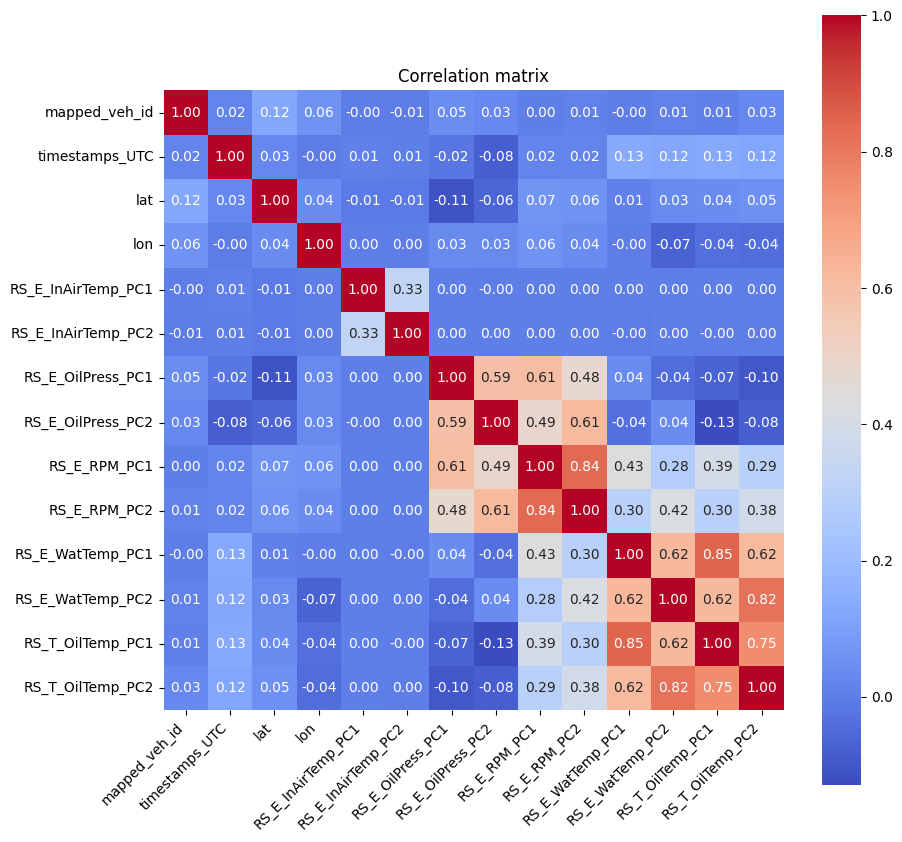

In [ ]:
def correlation_analysis(df):
    # cast timestamp to float64
    dfs = df
    dfs['timestamps_UTC'] = (dfs['timestamps_UTC'].astype('datetime64[ns]') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    # Calculate the correlation matrix
    corr_matrix = dfs.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    # Set the xticklabels and yticklabels to the column names of the DataFrame
    ax.set_xticklabels(corr_matrix.columns,rotation=45, horizontalalignment='right')
    ax.set_yticklabels(corr_matrix.columns,rotation=0)

    plt.title('Correlation matrix')
    plt.show()

correlation_analysis(ddf)
def data_quality_checks(df):
    # Check for missing values
    print("dataframe null values count")
    print(df.isnull().sum().compute())

    # Check for nan values
    print("dataframe nan values count")
    print(df.isna().sum().compute())

    # Check for duplicates
    print("dataframe duplicates count")
    print(df.compute().duplicated().sum())


    # let's Look for any signs of sensor malfunctions or inconsistencies.
    # Check for basic ouliers (if it's more than 3 standard deviations away from the mean.) 
    # in every features and "plot them"
    """for col in df.columns:
        if col not in ['timestamps_UTC', 'lat', 'lon', 'mapped_veh_id']:
                    n_outliers = ((df[col] - df[col].mean()).abs() > 3*df[col].std()).sum()

            print(f"Exploring {col}...")
    TODO: add code for outliers detection
    """
data_quality_checks(ddf)

Number of sensor1 outliers: 39946
Number of sensor2 outliers: 48751
Number of engine outliers: 113728


2023-12-12 15:51:02,462 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-12 15:58:03,981 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-12-12 16:00:08,563 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-12-12 16:02:02,044 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-12-12 16:03:30,146 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-12-12 16:05:41,219 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


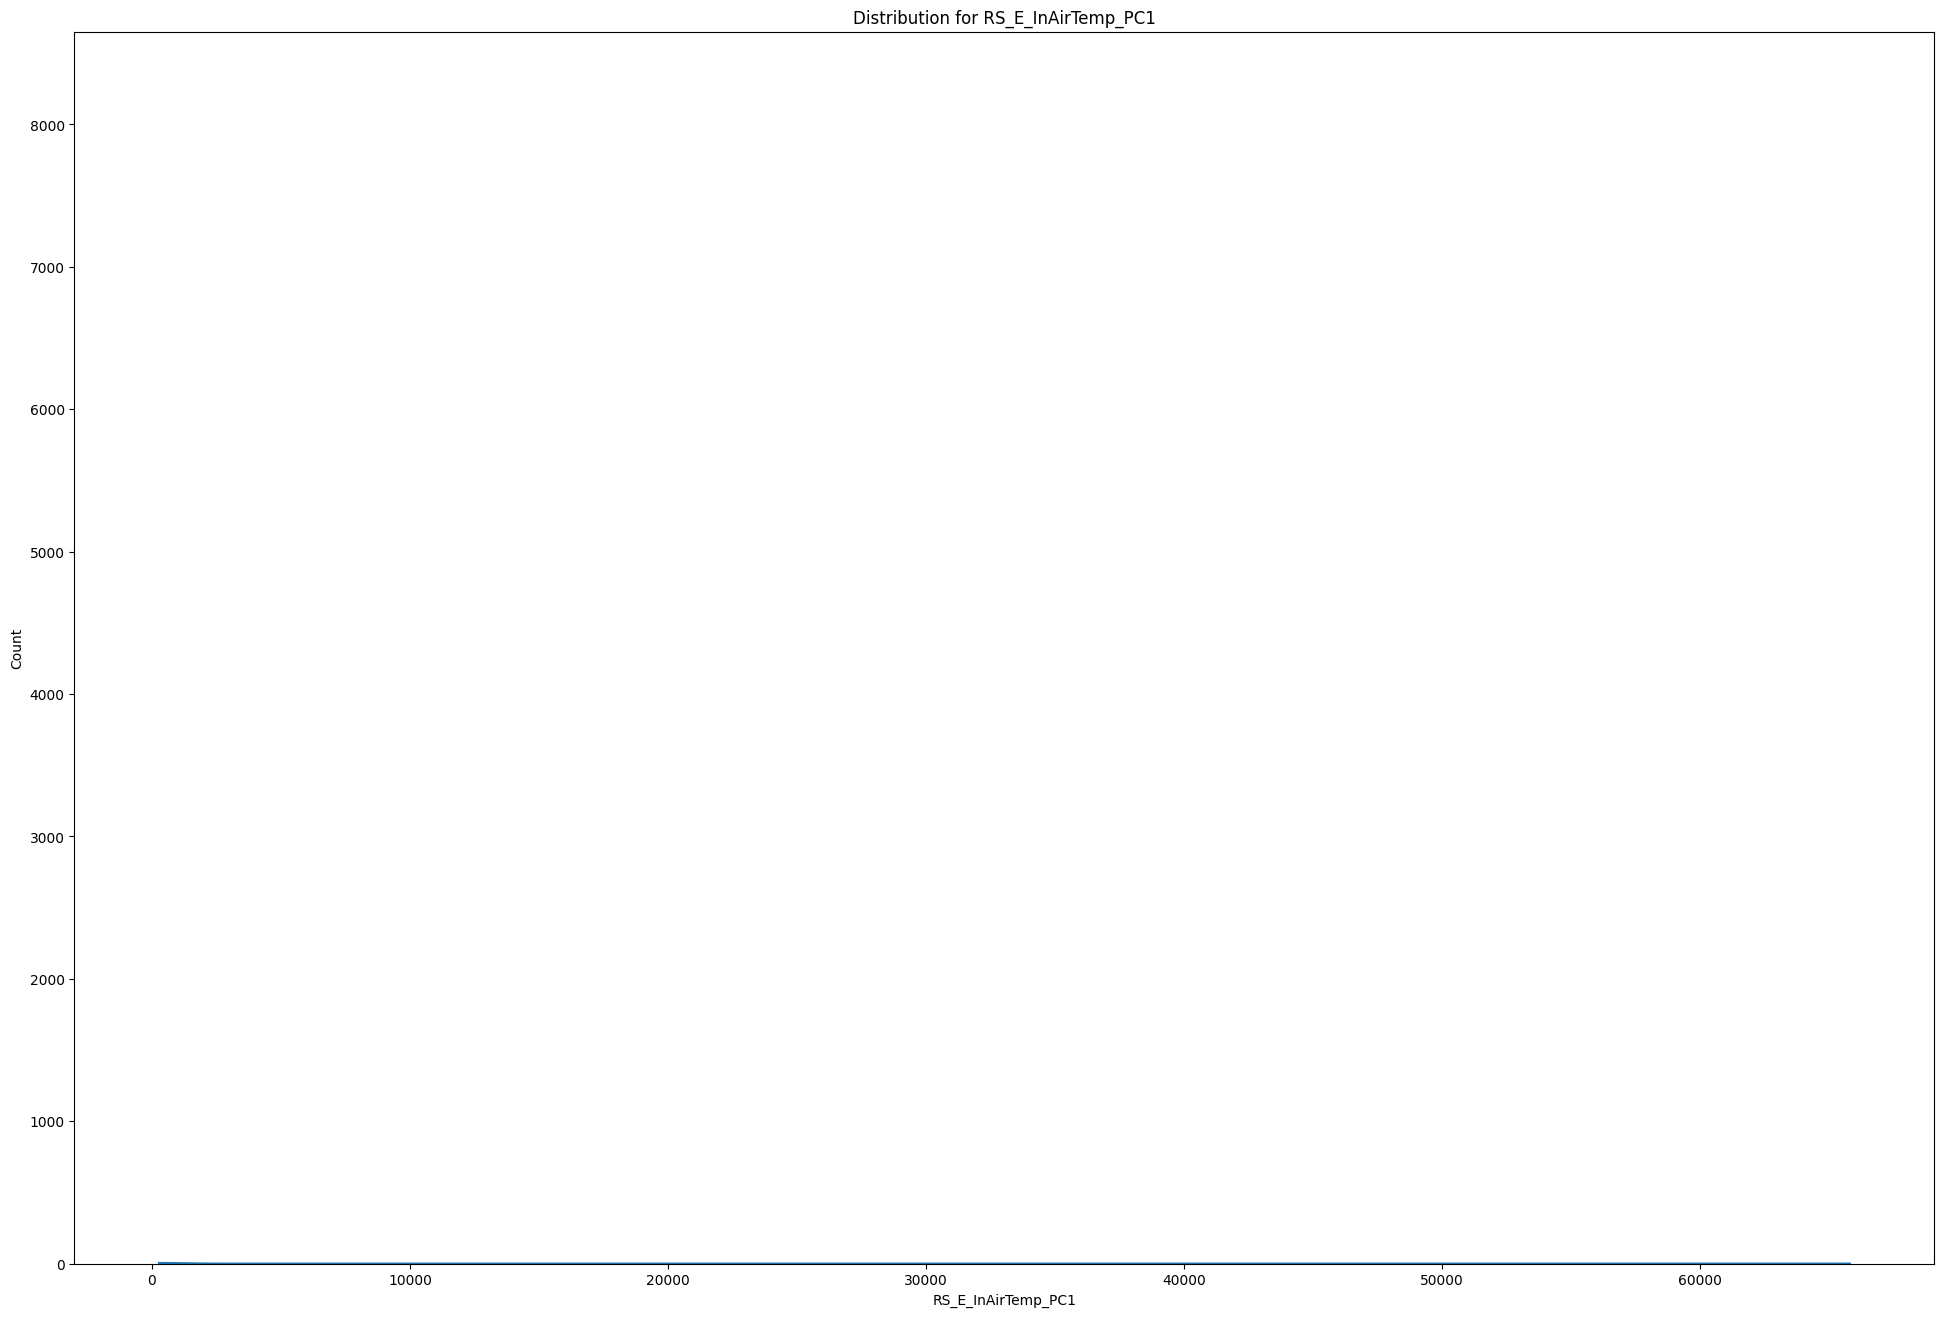

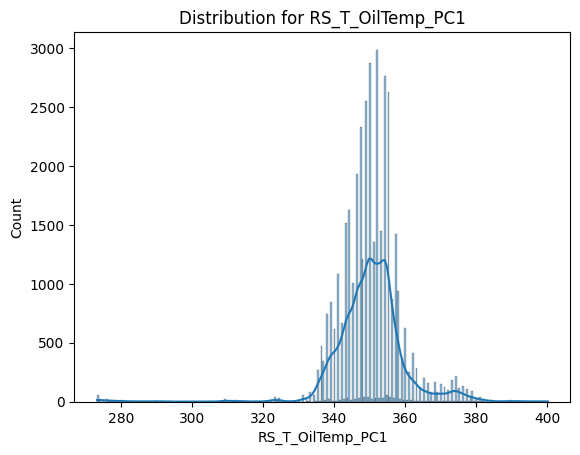

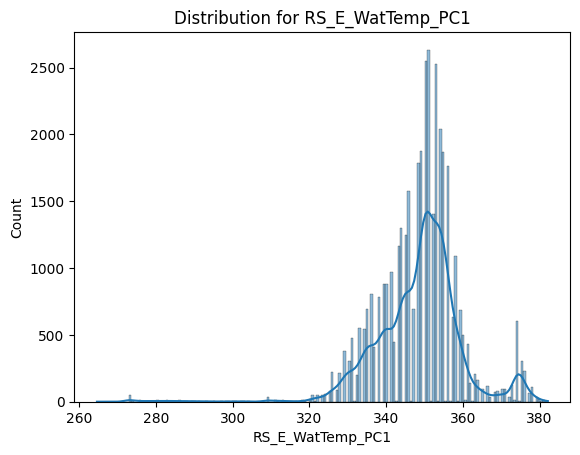

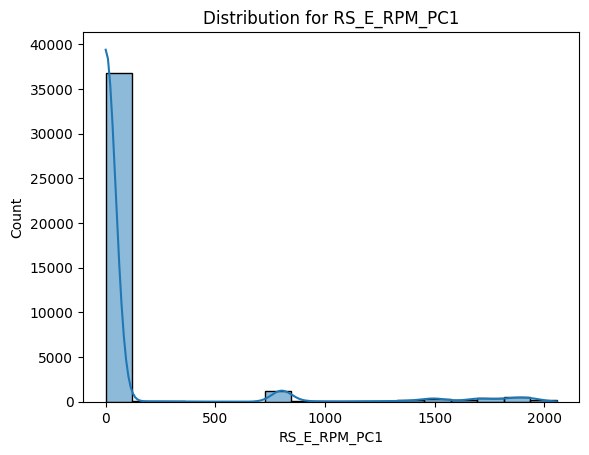

2023-12-12 16:15:14,547 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-12 16:17:29,004 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-12-12 16:18:11,882 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-12-12 16:18:53,294 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-12 16:19:41,647 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-12 16:20:45,518 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-12 16:22:04,825 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-12-12 16:23:57,929 - distributed.utils_perf - WARNING - full garbage collections took

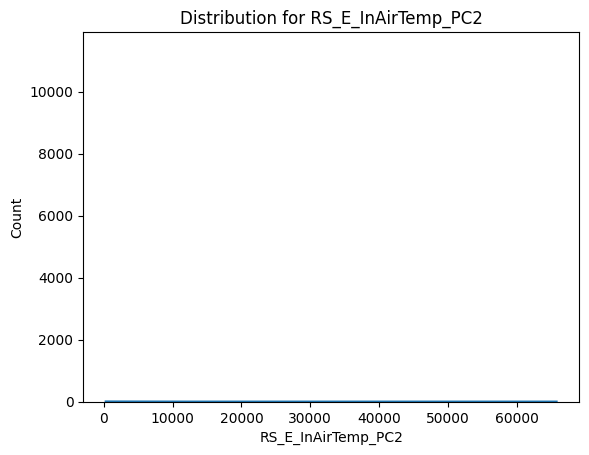

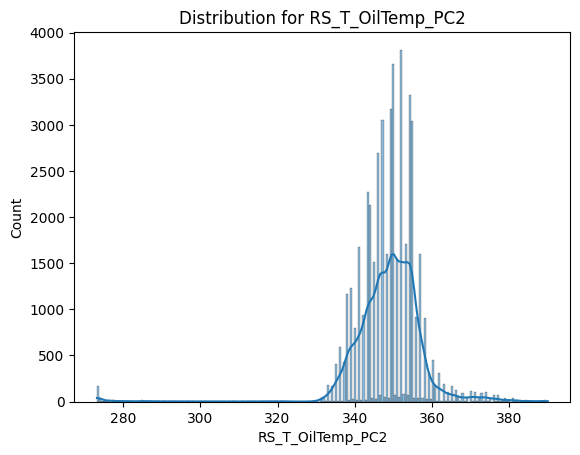

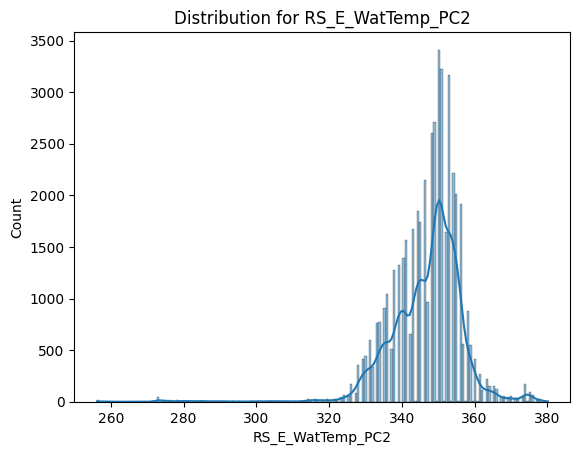

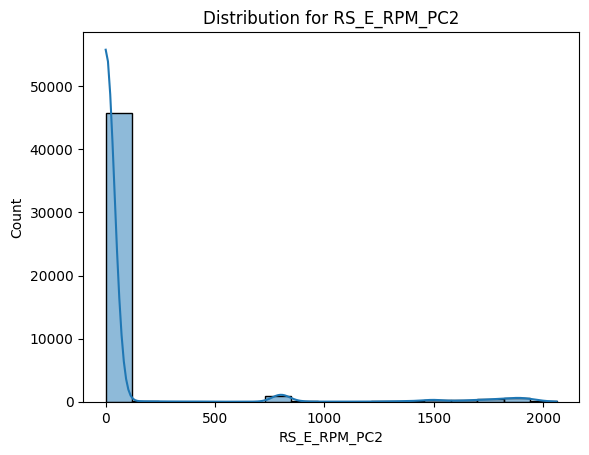

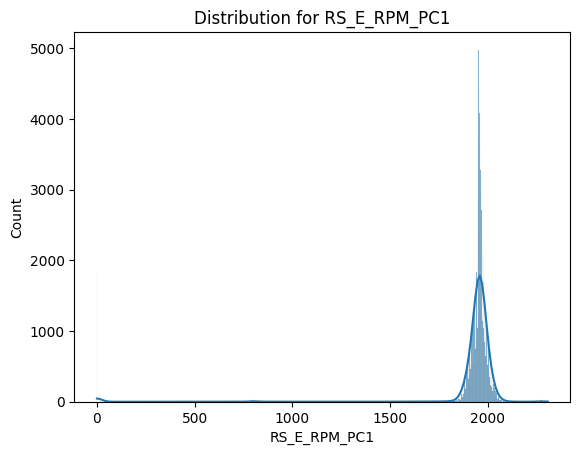

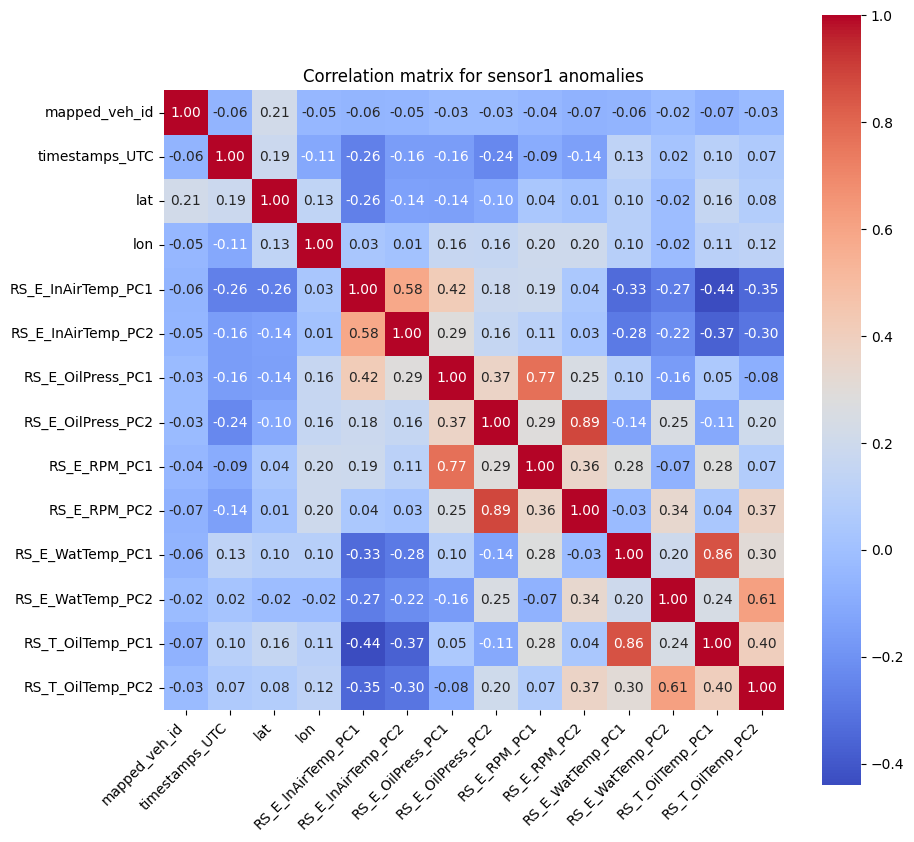

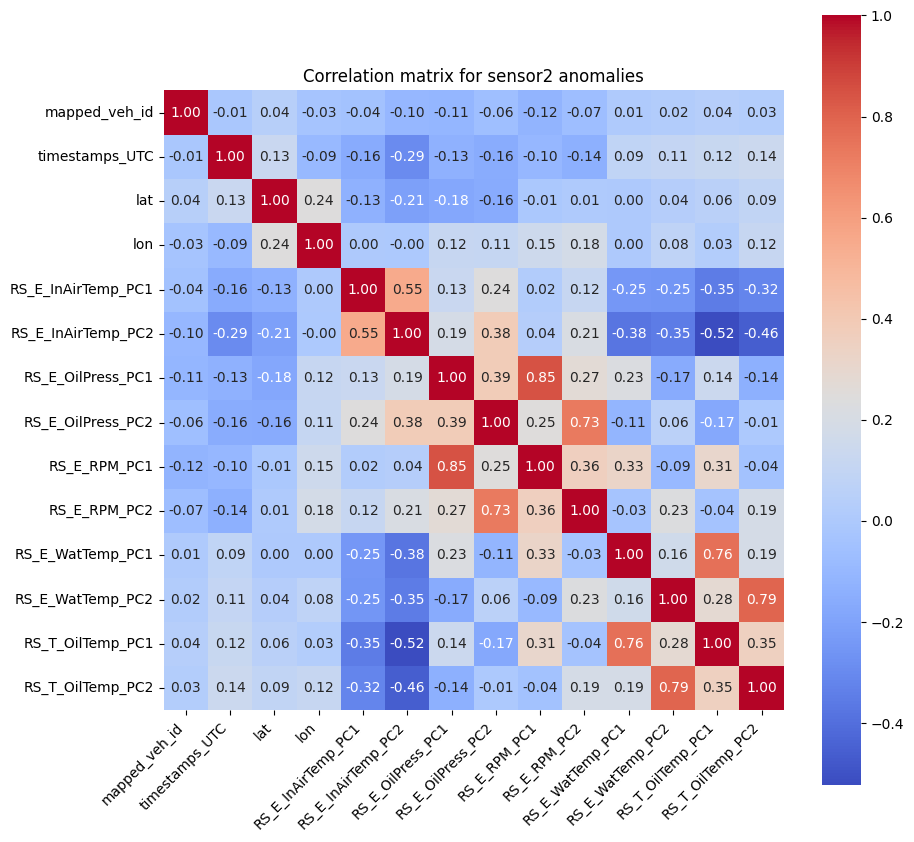

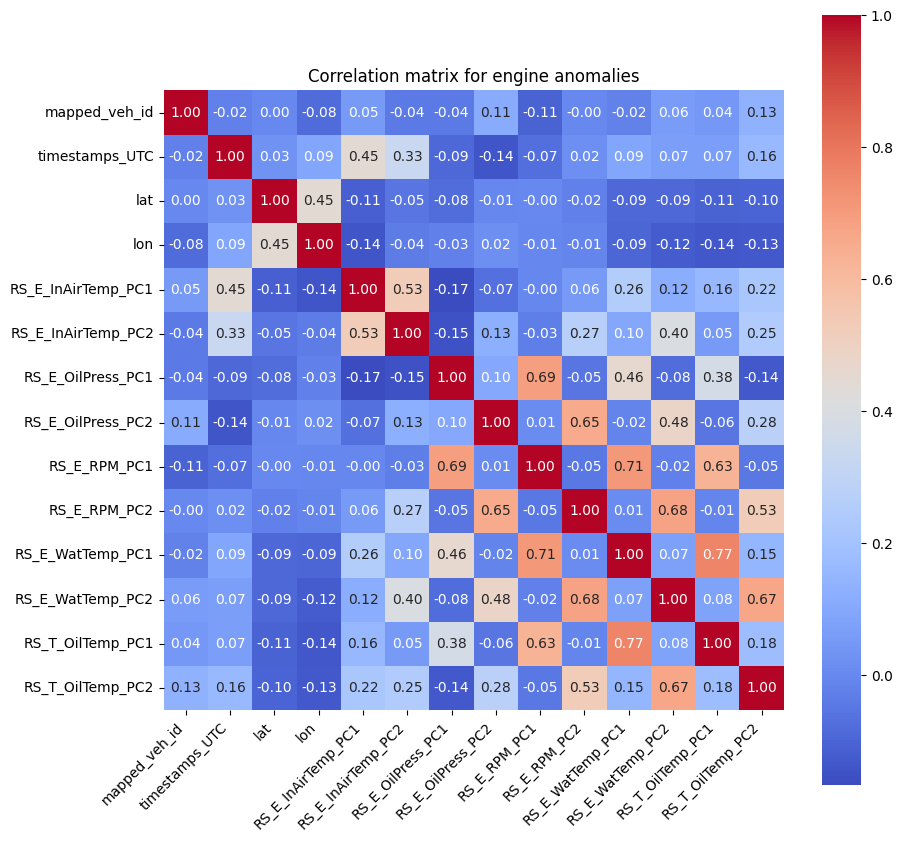

In [ ]:
def identify_easy_anomalies(df, max_Airtemp=65+273.15, max_Oiltemp=115+273.15,max_wattemp=100+273.15,
                        max_RPM=1950, ):
    # Identify sensors anomalies
    sensor1_anomalies = df[((df['RS_E_InAirTemp_PC1'] > max_Airtemp) | (df['RS_T_OilTemp_PC1'] > max_Oiltemp) | (df['RS_E_WatTemp_PC1'] > max_wattemp) & (df['RS_E_RPM_PC1']  >10))]
    print(f"Number of sensor1 outliers: {len(sensor1_anomalies)}")

    sensor2_anomalies = df[((df['RS_E_InAirTemp_PC2'] > max_Airtemp) | (df['RS_T_OilTemp_PC2'] > max_Oiltemp) | (df['RS_E_WatTemp_PC2'] > max_wattemp) & (df['RS_E_RPM_PC2']  > 10))]
    print(f"Number of sensor2 outliers: {len(sensor2_anomalies)}")

    # identify engine anomalies
    engine_anomalies = df[(df['RS_E_RPM_PC1'] > max_RPM) | (df['RS_E_RPM_PC2'] > max_RPM)]
    print(f"Number of engine outliers: {len(engine_anomalies)}")


    #plot anomalies
    plt.figure(figsize=(24, 16))
    sns.histplot(data=sensor1_anomalies['RS_E_InAirTemp_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_InAirTemp_PC1")
    plt.show()
    sns.histplot(data=sensor1_anomalies['RS_T_OilTemp_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_T_OilTemp_PC1")
    plt.show()
    sns.histplot(data=sensor1_anomalies['RS_E_WatTemp_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_WatTemp_PC1")
    plt.show()
    sns.histplot(data=sensor1_anomalies['RS_E_RPM_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_RPM_PC1")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_E_InAirTemp_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_InAirTemp_PC2")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_T_OilTemp_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_T_OilTemp_PC2")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_E_WatTemp_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_WatTemp_PC2")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_E_RPM_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_RPM_PC2")
    plt.show()
    sns.histplot(data=engine_anomalies['RS_E_RPM_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_RPM_PC1")
    plt.show()

    # plot outliers heatmap correlation
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(sensor1_anomalies.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    # Set the xticklabels and yticklabels to the column names of the DataFrame
    ax.set_xticklabels(sensor1_anomalies.corr().columns,rotation=45, horizontalalignment='right')
    ax.set_yticklabels(sensor1_anomalies.corr().columns,rotation=0)
    plt.title('Correlation matrix for sensor1 anomalies')
    plt.show()

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(sensor2_anomalies.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    # Set the xticklabels and yticklabels to the column names of the DataFrame
    ax.set_xticklabels(sensor2_anomalies.corr().columns,rotation=45, horizontalalignment='right')
    ax.set_yticklabels(sensor2_anomalies.corr().columns,rotation=0)
    plt.title('Correlation matrix for sensor2 anomalies')
    plt.show()

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(engine_anomalies.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    # Set the xticklabels and yticklabels to the column names of the DataFrame
    ax.set_xticklabels(engine_anomalies.corr().columns,rotation=45, horizontalalignment='right')
    ax.set_yticklabels(engine_anomalies.corr().columns,rotation=0)
    plt.title('Correlation matrix for engine anomalies')
    plt.show()
    
    # Return anomalies
    return sensor1_anomalies, sensor2_anomalies, engine_anomalies

sensor1_anomalies, sensor2_anomalies, engine_anomalies = identify_easy_anomalies(ddf)

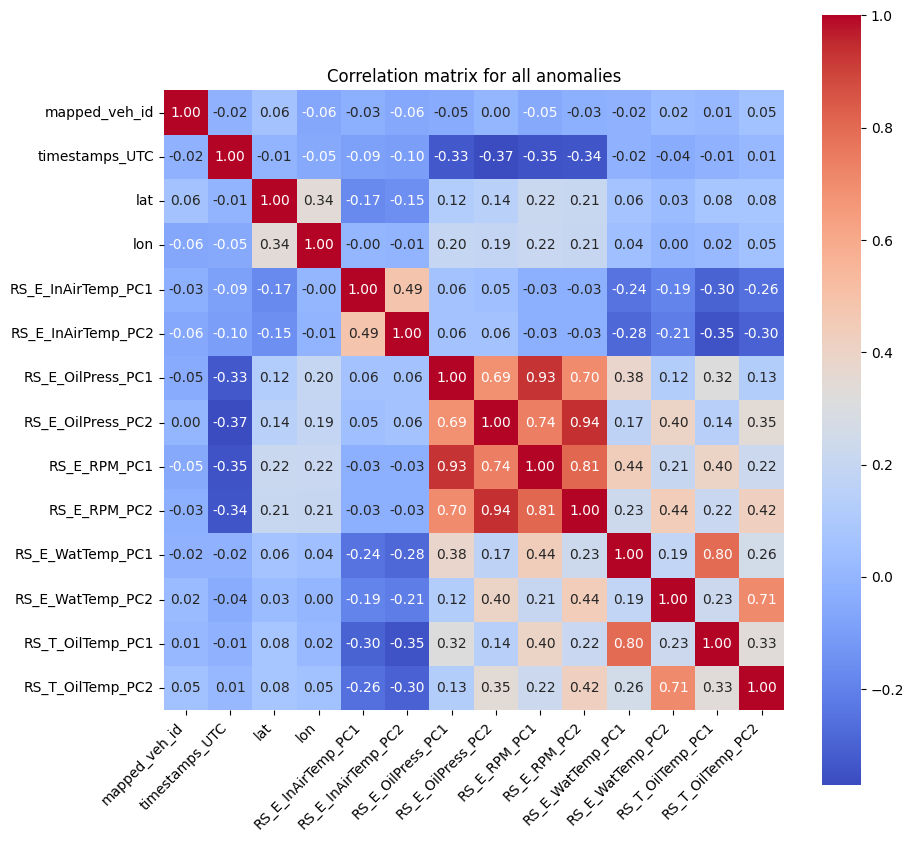

In [ ]:
# combine all anomalies and plot heatmap correlation
all_anomalies = dd.concat([sensor1_anomalies, sensor2_anomalies, engine_anomalies])
plt.figure(figsize=(10, 10))
ax = sns.heatmap(all_anomalies.corr().compute(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
# Set the xticklabels and yticklabels to the column names of the DataFrame
ax.set_xticklabels(all_anomalies.corr().compute().columns,rotation=45, horizontalalignment='right')
ax.set_yticklabels(all_anomalies.corr().compute().columns,rotation=0)
plt.title('Correlation matrix for all anomalies')
plt.show()

# Phase 3: Data Preparation
This phase covers constructing the final data set for modeling tools. Steps include selecting data, cleansing data, constructing data, integrating data, and formatting data.

Select Data:

Decide on data based on relevance, quality, and technical constraints.
Explain data inclusions/exclusions and prioritize attributes.
Clean Data:

Ensure data cleanliness, address missing values using appropriate techniques.
Document how quality problems were addressed.
Construct Data:

Develop new records or derived attributes, considering modeling needs.
Example: Create "income per head" as a derived attribute.
Integrate Data:

Combine information from multiple tables or records.
Perform aggregations to summarize information.
Format Data:

Change data format or design to suit modeling tools.
Example: Trim strings, reorganize information.

In [ ]:

# format the time in a more human readable way
print("Last run:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

